# Nina Stawski's (group 90) final project report
## Paper #39
## When More is Less: Incorporating Additional Datasets Can Hurt Performance By Introducing Spurious Correlations [10.48550/arXiv.2308.04431](https://doi.org/10.48550/arXiv.2308.04431)

Illinois ID: ninas2

* **[VIDEO LINK](https://youtu.be/ikw3XVGCM28)**
* [My Final project GitHub repo link](https://github.com/nstawski/dlh-final-project)

* [Original paper GitHub repo](https://github.com/basedrhys/ood-generalization)

# Introduction

## Background of the problem

### Type of problem
  
  This is a data preparation and processing problem. The authors of the article are testing a common belief that adding more data improves the resulting model performance. Their main hypothesis, which they subsequently prove, is that incorporating more data does not necessary improve the model performance. It can introduce spurious correlations, and hurt the resulting model performance rather than helping it.

### What is the importance/meaning of solving the problem
  
  The paper is challenging a common belief, meaning a lot of researchers are likely trying to incorporate as much data as they can expecting it would improve the performance of their models. The outcome of this research would provide guidance on the possible pitfalls and the cases where you wouldn't want to add external data - so it could set a new standard of processing and incorporating data for everyone in the field.

### The difficulty of the problem

  The problem is non-obvious and the paper is challenging the common belief held in the industry. The authors are putting a lot of state-of-the-art approaches to the test, and attempt to quantify the results as well as provide new standards and explanations. This is extremely hard to do so I believe the problem is difficult.

### The state of the art methods and effectiveness

  The "industry standard" way of improving model performance is adding more data from additional datasets, which the authors of this article prove to not be effective, and even being harmful in many cases.

  One of the main issues causing the model performance decrease when adding more data from other sources is spurious correlations, which in case of x-rays could be coming even from the scanner artifacts, or other hospital-specific data. One of the state-of-the-art ways to mitigate this is balancing a dataset to reduce the influence of hospital-specific factors. While balancing definitely improved the situation, the resulting model performance was still in many cases worse than with a single-hospital dataset.


## Paper explanation
### What did the paper propose
The paper used four most-used chest x-ray datasets - MIMIC-CXR-JPG, CheXpert, PadChest, ChestXray8 - to disprove a popular belief that adding more data always would improve the performance of your model. They postulate that, for the specific x-ray data, even the scanners themselves, the way hospitals produce data, or send specific patients to specific places to do their scan, can introduce spurious correlations which, in many cases, significantly affect the worst group performance.

### What is the innovations of the method
Existing research (for example, John R Zech, Marcus A Badgeley, Manway Liu, Anthony B Costa, Joseph J Titano, and Eric Karl Oermann. Variable generalization performance of a deep learning model to detect pneumonia in chest radiographs: a cross-sectional study. PLoS medicine, 15(11): e1002683, 2018.) proves that adding a second dataset improves the average per-group accuracy. In contrast, the paper I am reproducing focuses on the worst per-group accuracy.

### How well the proposed method work (in its own metrics)
According to the article authors, their method works really well and proves that in nearly 50% of cases adding a second dataset, and even balancing it to reduce spurious correllations doesn't get the model to perform better than without that additional dataset. The models pick up on hospital-specific features even if those features weren't explicitly defined in the original data. They postulate that every CNN model, regardless of training disease or datasets, learns embeddings that can distinguish any of the hospital sources with near-perfect accuracy, even if the embeddings were trained via one or two hospitals’ data.

### What is the contribution to the reasearch regime (referring the Background above, how important the paper is to the problem).

The article cautions against blindly adding more datasets, and provides a number of approaches you can take if you still decide to do so. The conclusion is adding more data shouldn't be done blindly. The authors of the article definitely discourage the researchers from the most common approach of throwing data at the problem to improve model performance.


# Scope of Reproducibility:

List hypotheses from the paper you will test and the corresponding experiments you will run.

![Paper overview](https://raw.githubusercontent.com/basedrhys/ood-generalization/5d8ff09eba4c0b4b20b5ae2814fe865bed1dfb0e/img/high_level_overview.png)

## Hypothesis 1

In 43% of training dataset/disease tasks, adding data from an external source hurts worst-group performance.


## Hypothesis 2

Balancing the dataset to reduce spurious correlations is often beneficial, but in the scenarios where adding an additional data source hurts generalization performance, it does not always improve generalization; in some cases, training on a balanced dataset achieves lower worst-group accuracy than training on datasets from one or two hospitals.


# Methodology

This methodology is the core of your project. It consists of run-able codes with necessary annotations to show the expeiment you executed for testing the hypotheses.

The methodology at least contains two subsections **data** and **model** in your experiment.

## Python environment and package versions

In [5]:
# !pip install importlib
# !pip install torch
# !pip install torchvision
# !pip install pandas
# !pip install matplotlib
# !pip install imblearn

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
from os.path import exists
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageFile

import json
import random
from IPython.display import display
from datetime import datetime
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix



import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import Data_Constants as Constants

#making sure all referenced files are reloaded
import importlib
importlib.reload(Constants)


<module 'Data_Constants' from 'C:\\Users\\Stan\\Documents\\GitHub\\dlh-final-project\\Data_Constants.py'>

I have originally set up the Jupyter Notebook and was running the code on my laptop. However, processing of the data took days and the training was promising to take months. My husband had a gaming computer with a powerful video card and Cuda available, so I ended up using his machine.

To keep the environment isolated, I installed `Anaconda` and created a separate environment for all my packages. I then ran `Jupyter` with access to local network and opened my notebook remotly from my laptop:

```
jupyter notebook --ip 192.168.x.xxx --port 8888
```

Original requirements listed a bit different versions, but due to package compatibility I had to update them. Most significant changes were: install a version of torch that supports Cuda, and upgrade `torchvision` to `0.9.1`

In [2]:
env_df = pd.read_csv('env_packages.csv', header=None, names=['Package', 'Version'])
styled_env_df = env_df.style.set_table_styles([
    {'selector': 'th, td',
     'props': [('min-width', '200px')]},
    {'selector': 'table',
     'props': [('width', '70%')]}
]).set_properties(**{
    'background-color': 'white',
    'color': 'black',
    'border-color': 'black',
    'border-style': 'solid',
    'border-width': '1px'
}).hide_index()

styled_env_df

Package,Version
python,3.6.13
pip,21.2.2
jupyter_core,4.8.1
imbalanced-learn,0.8.1
jupyter,1.0.0
matplotlib,2.2.2
numpy,1.19.5
pandas,1.1.0
pillow,8.4.0
scikit-learn,0.24.2


It was a lot of debugging to make sure Cuda is available in the notebook, and it took me a few days to finally make it work. It made all processing and training code run a lot faster.

The next challenge I encountered was that the full source data did not fit into my laptop and I had to get an external storage to hold it - however, that external storage's speed wasn't keeping up. So instead, my husband got an upgrade to his internal storage with a very fast ssd.

In [3]:
# os.environ['KMP_DUPLICATE_LIB_OK']='True'
# torch.set_default_device('cuda')

torch.set_default_tensor_type('torch.cuda.FloatTensor')
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

print("Cuda is available:", torch.cuda.is_available())

Cuda is available: True


#  Data
The study is using four datasets: MIMIC-CXR-JPG, CheXpert, PadChest, ChestXray8

The datasets are being filtered to include only frontal (PA/AP) images. Instances are labeled with one or more pathologies. Each dataset has a different set of diseases but they are preprocessed using code derived from ClinicalDG2 (Zhang et al., 2021) to extract the eight common labels and homogenize the datasets. Additionally, authors of the article created the Any label which indicates a positive label for any of the seven common disease labels, resulting in nine different binary labels. All experiments use the labels in a binary manner; a pathology is chosen as the target label, with an instance labeled 1 if the pathology of interest is present and 0 otherwise. 

The autors apply an 80%/10%/10% subject-wise train/val/test split, with the same split used across seeds.

### MIMIC-CXR

1. [Obtain access](https://mimic-cxr.mit.edu/about/access/) to the MIMIC-CXR-JPG Database Database on PhysioNet and download the [dataset](https://physionet.org/content/mimic-cxr-jpg/2.0.0/). The best option is downloading from the GCP bucket:

```sh
gcloud auth login
mkdir MIMIC-CXR-JPG
gsutil -m rsync -d -r gs://mimic-cxr-jpg-2.0.0.physionet.org MIMIC-CXR-JPG
```

2. In order to obtain gender information for each patient, you will need to obtain access to [MIMIC-IV](https://physionet.org/content/mimiciv/0.4/). Download `core/patients.csv.gz` and place the file in the `MIMIC-CXR-JPG` directory.

### CheXpert
1. Sign up with your email address [here](https://stanfordmlgroup.github.io/competitions/chexpert/).

2. Download either the original or the downsampled dataset (we recommend the downsampled version - `CheXpert-v1.0-small.zip`) and extract it.

### ChestX-ray8

1. Download the `images` folder and `Data_Entry_2017_v2020.csv` from the [NIH website](https://nihcc.app.box.com/v/ChestXray-NIHCC).

2. Unzip all of the files in the `images` folder.

### PadChest

1. The paper uses a resized version of PadChest, which can be downloaded [here](https://academictorrents.com/details/96ebb4f92b85929eadfb16761f310a6d04105797).

2. Unzip `images-224.tar`.

  * Statistics: include basic descriptive statistics of the dataset like size, cross validation split, label distribution, etc.
  * Data process: how do you munipulate the data, e.g., change the class labels, split the dataset to train/valid/test, refining the dataset.
  * Illustration: printing results, plotting figures for illustration.
  * You can upload your raw dataset to Google Drive and mount this Colab to the same directory. If your raw dataset is too large, you can upload the processed dataset and have a code to load the processed dataset.
  
## Data Processing
The original pre-processing for the article was done using the scripts outside of the Jupyter Notebook. Some of them didnt' work for me, and the installation process didn't succeed despite multiple attempts either. Instead, I have adapted some of the original scripts to run in the notebook (with some modifications so they actually work with my data), using the external "Constants.py" file that points to the location of the datasets.
1. In `./Data_Constants.py`, update `image_paths` to point to each of the four directories that you downloaded.

2. Run the next two cells to pre-process the data

## Validating
I am using the validation and pre-processing code provided by the authors of the article, with some modifications to make it run as expected.

In [4]:
#making sure constants are up to date if they were changed
importlib.reload(Constants)

def validate_mimic():
    img_dir = Path(Constants.image_paths['MIMIC'])
    meta_dir = Path(Constants.meta_paths['MIMIC'])
    
    print('meta_dir', meta_dir, os.getcwd())
    print('meta_dir', meta_dir/'mimic-cxr-2.0.0-metadata.csv')
    assert (meta_dir/'mimic-cxr-2.0.0-metadata.csv').is_file()
    assert (meta_dir/'mimic-cxr-2.0.0-negbio.csv').is_file()
    assert (meta_dir/'patients.csv').is_file()
    # modified the file that's being checked since I don't have the full MIMIC-CXR-JPG dataset due to space limitations
    # in the original script, the file in p19 was being checked.
    assert (img_dir/'p10/p10000032/s50414267/02aa804e-bde0afdd-112c0b34-7bc16630-4e384014.jpg').is_file()

def validate_cxp():
    img_dir = Path(Constants.image_paths['CXP'])
    if (img_dir/'CheXpert-v1.0').is_dir():
        cxp_subfolder = 'CheXpert-v1.0'
    else:
        cxp_subfolder = 'CheXpert-v1.0-small'
    assert (img_dir/cxp_subfolder/'train.csv').is_file()
    assert (img_dir/cxp_subfolder/'train/patient48822/study1/view1_frontal.jpg').is_file()
    assert (img_dir/cxp_subfolder/'valid/patient64636/study1/view1_frontal.jpg').is_file()

def validate_pad():
    img_dir = Path(Constants.image_paths['PAD'])
    meta_dir = Path(Constants.meta_paths['PAD'])
    assert (meta_dir/'PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv').is_file()
    assert (img_dir/'185566798805711692534207714722577525271_qb3lyn.png').is_file()

def validate_nih():
    img_dir = Path(Constants.image_paths['NIH'])
    meta_dir = Path(Constants.meta_paths['NIH'])
    assert (meta_dir/'Data_Entry_2017.csv').is_file()
    assert (img_dir/'images/00002072_003.png').is_file()

def validate_splits():
    for dataset in Constants.df_paths:
        for split in Constants.df_paths[dataset]:
            assert Path(Constants.df_paths[dataset][split]).is_file()


def validate_all():
    validate_mimic()
    validate_cxp()
    validate_nih()
    validate_pad()


## Data pre-processing setup

In [5]:
# making sure constants are up to date if they were changed after running this notebook
importlib.reload(Constants)

def preprocess_mimic():
    img_dir = Path(Constants.image_paths['MIMIC'])
    meta_dir = Path(Constants.meta_paths['MIMIC'])
    out_folder = meta_dir/'clinicaldg'
    out_folder.mkdir(parents = True, exist_ok = True)  

    patients = pd.read_csv(meta_dir/'patients.csv')
    labels = pd.read_csv(meta_dir/'mimic-cxr-2.0.0-negbio.csv')
    meta = pd.read_csv(meta_dir/'mimic-cxr-2.0.0-metadata.csv')

    df = meta.merge(patients, on = 'subject_id').merge(labels, on = ['subject_id', 'study_id'])
    df['age_decile'] = pd.cut(df['anchor_age'], bins = list(range(0, 100, 10))).apply(lambda x: f'{x.left}-{x.right}').astype(str)
    df['frontal'] = df.ViewPosition.isin(['AP', 'PA'])

    df['path'] = df.apply(lambda x: os.path.join(f'p{str(x["subject_id"])[:2]}', f'p{x["subject_id"]}', f's{x["study_id"]}', f'{x["dicom_id"]}.jpg'), axis = 1)
    df.to_csv(out_folder/"preprocessed.csv", index=False)

def preprocess_pad():
    # I have modified this function from the original one, because I was getting missing/ambiguous Dtype errors
    img_dir = Path(Constants.image_paths['PAD'])
    meta_dir = Path(Constants.meta_paths['PAD'])
    out_folder = meta_dir/'clinicaldg'
    out_folder.mkdir(parents=True, exist_ok=True)

    dtype_spec = {
        'ImageID': str,
        'StudyID': str,
        'PatientID': str,
        'PatientBirth': str, # converting this to the integer later to avoid processing errors (due some data apparently being saved as float)
        'PatientSex_DICOM': str,
        'ViewPosition_DICOM': str,
        'Projection': str,
        'Labels': str,
        'WindowCenter_DICOM': str,
        'WindowWidth_DICOM': str
    }

    df = pd.read_csv(meta_dir/'PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv', dtype=dtype_spec)
    df = df[['ImageID', 'StudyID', 'PatientID', 'PatientBirth', 'PatientSex_DICOM', 'ViewPosition_DICOM', 'Projection', 'Labels']]
    df = df[~df["Labels"].isnull()]
    df = df[df["ImageID"].apply(lambda x: os.path.exists(os.path.join(img_dir, x)))]
    df = df[df.Projection.isin(['PA', 'L', 'AP_horizontal', 'AP'])]

    df['frontal'] = ~(df['Projection'] == 'L')
    df = df[~df['Labels'].apply(lambda x: 'exclude' in x or 'unchanged' in x)]

    mapping = dict()
    mapping['Effusion'] = ['hydropneumothorax', 'empyema', 'hemothorax']
    mapping["Consolidation"] = ["air bronchogram"]
    mapping['No Finding'] = ['normal']

    for pathology in Constants.take_labels:
        mask = df["Labels"].str.contains(pathology.lower())
        if pathology in mapping:
            for syn in mapping[pathology]:
                mask |= df["Labels"].str.contains(syn.lower())
        df[pathology] = mask.astype(int)

    df['PatientBirth'] = df['PatientBirth'].dropna().astype(float).astype(int)
    df['Age'] = 2017 - df['PatientBirth']
    df.reset_index(drop=True).to_csv(out_folder/"preprocessed.csv", index=False)


def preprocess_cxp():
    img_dir = Path(Constants.image_paths['CXP'])
    out_folder = img_dir/'clinicaldg'
    if (img_dir/'CheXpert-v1.0'/'train.csv').is_file():
        df = pd.concat([pd.read_csv(img_dir/'CheXpert-v1.0'/'train.csv'), 
                        pd.read_csv(img_dir/'CheXpert-v1.0'/'valid.csv')],
                        ignore_index = True)
    elif (img_dir/'CheXpert-v1.0-small'/'train.csv').is_file(): 
        df = pd.concat([pd.read_csv(img_dir/'CheXpert-v1.0-small'/'train.csv'),
                        pd.read_csv(img_dir/'CheXpert-v1.0-small'/'valid.csv')],
                        ignore_index = True)
    elif (img_dir/'train.csv').is_file():
        raise ValueError('Please set Constants.image_paths["CXP"] to be the PARENT of the current'+
                ' directory and rerun this script.')
    else:
        raise ValueError("CheXpert files not found!")

    out_folder.mkdir(parents = True, exist_ok = True)  

    df['subject_id'] = df['Path'].apply(lambda x: int(Path(x).parent.parent.name[7:]))
    df['Path'] = df['Path'].apply(lambda x: str(x).replace("CheXpert-v1.0/", ""))
    df.reset_index(drop = True).to_csv(out_folder/"preprocessed.csv", index=False)

def preprocess_nih():
    img_dir = Path(Constants.image_paths['NIH'])
    meta_dir = Path(Constants.meta_paths['NIH'])
    out_folder = meta_dir/'clinicaldg'
    out_folder.mkdir(parents = True, exist_ok = True)  
    df = pd.read_csv(meta_dir/"Data_Entry_2017.csv")
    df['labels'] = df['Finding Labels'].apply(lambda x: x.split('|'))

    for label in Constants.take_labels:
        df[label] = df['labels'].apply(lambda x: label in x)
    df.reset_index(drop = True).to_csv(out_folder/"preprocessed.csv", index=False)

In [103]:
%%script false --no-raise-error
# skipping this cell since I already ran this.

if __name__ == '__main__':
    print("Validating paths...")
    validate_all()
    print("Preprocessing MIMIC-CXR...")
    preprocess_mimic()
    print("Preprocessing CheXpert...")
    preprocess_cxp()
    print("Preprocessing ChestX-ray8...")
    preprocess_nih()
    print("Preprocessing PadChest... This might take a few minutes...")
    preprocess_pad()
    print("Done.")

Validating paths...
meta_dir C:\Nina\e-root\data\mimic\physionet.org\files\mimic-cxr-jpg\2.0.0 C:\Users\Stan\Documents\GitHub\dlh-final-project
meta_dir C:\Nina\e-root\data\mimic\physionet.org\files\mimic-cxr-jpg\2.0.0\mimic-cxr-2.0.0-metadata.csv
Preprocessing MIMIC-CXR...
Preprocessing CheXpert...
Preprocessing ChestX-ray8...
Preprocessing PadChest... This might take a few minutes...
Done.


### Next, we need to resize and process the data.
I am using the code provided by the authors of the article to do this.

In [6]:
def process_MIMIC(split, only_frontal):  
    copy_subjectid = split['subject_id']     
    split = split.drop(columns = ['subject_id']).replace(
            [[None], -1, "[False]", "[True]", "[ True]", 'UNABLE TO OBTAIN', 'UNKNOWN', 'MARRIED', 'LIFE PARTNER',
             'DIVORCED', 'SEPARATED', '0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90',
             '>=90'],
            [0, 0, 0, 1, 1, 0, 0, 'MARRIED/LIFE PARTNER', 'MARRIED/LIFE PARTNER', 'DIVORCED/SEPARATED',
             'DIVORCED/SEPARATED', '0-20', '0-20', '20-40', '20-40', '40-60', '40-60', '60-80', '60-80', '80-', '80-'])
    
    split['subject_id'] = copy_subjectid.astype(str)
    split['study_id'] = split['study_id'].astype(str)
    split['Age'] = split["age_decile"]
    split['Sex'] = split["gender"]
    split = split.rename(
        columns = {
            'Pleural Effusion':'Effusion',   
        })
    split['path'] = split['path'].astype(str).apply(lambda x: os.path.join(Constants.image_paths['MIMIC'], x))
    if only_frontal:
        split = split[split.frontal]
        
    split['env'] = 'MIMIC'  
    split.loc[split.Age == 0, 'Age'] = '0-20'
    
    return split[['subject_id','path','Sex',"Age", 'env', 'frontal', 'study_id'] + Constants.take_labels]

def process_NIH(split, only_frontal = True):
    split['Patient Age'] = np.where(split['Patient Age'].between(0,19), 19, split['Patient Age'])
    split['Patient Age'] = np.where(split['Patient Age'].between(20,39), 39, split['Patient Age'])
    split['Patient Age'] = np.where(split['Patient Age'].between(40,59), 59, split['Patient Age'])
    split['Patient Age'] = np.where(split['Patient Age'].between(60,79), 79, split['Patient Age'])
    split['Patient Age'] = np.where(split['Patient Age']>=80, 81, split['Patient Age'])
    
    copy_subjectid = split['Patient ID'] 
    
    split = split.drop(columns = ['Patient ID']).replace([[None], -1, "[False]", "[True]", "[ True]", 19, 39, 59, 79, 81], 
                            [0, 0, 0, 1, 1, "0-20", "20-40", "40-60", "60-80", "80-"])
   
    split['subject_id'] = copy_subjectid.astype(str)
    split['Sex'] = split['Patient Gender'] 
    split['Age'] = split['Patient Age']
    split = split.drop(columns=["Patient Gender", 'Patient Age'])
    split['path'] = split['Image Index'].astype(str).apply(lambda x: os.path.join(Constants.image_paths['NIH'], 'images', x))
    split['env'] = 'NIH'
    split['frontal'] = True
    split['study_id'] = split['subject_id'].astype(str)
    return split[['subject_id','path','Sex',"Age", 'env', 'frontal','study_id'] + Constants.take_labels]


def process_CXP(split, only_frontal):
    split['Age'] = np.where(split['Age'].between(0,19), 19, split['Age'])
    split['Age'] = np.where(split['Age'].between(20,39), 39, split['Age'])
    split['Age'] = np.where(split['Age'].between(40,59), 59, split['Age'])
    split['Age'] = np.where(split['Age'].between(60,79), 79, split['Age'])
    split['Age'] = np.where(split['Age']>=80, 81, split['Age'])
    
    copy_subjectid = split['subject_id'] 
    split = split.drop(columns = ['subject_id']).replace([[None], -1, "[False]", "[True]", "[ True]", 19, 39, 59, 79, 81], 
                            [0, 0, 0, 1, 1, "0-20", "20-40", "40-60", "60-80", "80-"])
    
    split['subject_id'] = copy_subjectid.astype(str)
    split['Sex'] = np.where(split['Sex']=='Female', 'F', split['Sex'])
    split['Sex'] = np.where(split['Sex']=='Male', 'M', split['Sex'])
    split = split.rename(
        columns = {
            'Pleural Effusion':'Effusion',
            'Lung Opacity': 'Airspace Opacity'        
        })
    split['path'] = split['Path'].astype(str).apply(lambda x: os.path.join(Constants.image_paths['CXP'], x))
    split['frontal'] = (split['Frontal/Lateral'] == 'Frontal')
    if only_frontal:
        split = split[split['frontal']]
    split['env'] = 'CXP'
    split['study_id'] = split['path'].apply(lambda x: x[x.index('patient'):x.rindex('/')])
    return split[['subject_id','path','Sex',"Age", 'env', 'frontal','study_id'] + Constants.take_labels]


def process_PAD(split, only_frontal):
    split['Age'] = np.where(split['Age'].between(0,19), 19, split['Age'])
    split['Age'] = np.where(split['Age'].between(20,39), 39, split['Age'])
    split['Age'] = np.where(split['Age'].between(40,59), 59, split['Age'])
    split['Age'] = np.where(split['Age'].between(60,79), 79, split['Age'])
    split['Age'] = np.where(split['Age']>=80, 81, split['Age'])
    
    split = split.replace([[None], -1, "[False]", "[True]", "[ True]", 19, 39, 59, 79, 81], 
                            [0, 0, 0, 1, 1, "0-20", "20-40", "40-60", "60-80", "80-"])
    
    split.loc[split['Age'] == 0.0, 'Age'] = '0-20'
    split.loc[split['Age'].isnull(), 'Age'] = '0-20'
    split = split.rename(columns = {
        'PatientID': 'subject_id',
        'StudyID': 'study_id',
        'PatientSex_DICOM' :'Sex'        
    })
    
    split.loc[~split['Sex'].isin(['M', 'F', 'O']), 'Sex'] = 'O'
    split['path'] =  split['ImageID'].astype(str).apply(lambda x: os.path.join(Constants.image_paths['PAD'], x))
    if only_frontal:
        split = split[split['frontal']]
    split['env'] = 'PAD'
    return split[['subject_id','path','Sex',"Age", 'env', 'frontal','study_id'] + Constants.take_labels]


def split(df, split_portions = (0.8, 0.9), seed=0):
    # We don't want the data splits to be affected by seed
    # So lets temporarily set the seed to a static value...
    rand_state = np.random.get_state()
    np.random.seed(seed)

    # Split our data (irrespective of the random seed provided in train.py)
    subject_df = pd.DataFrame({'subject_id': np.sort(df['subject_id'].unique())})
    subject_df['random_number'] = np.random.uniform(size=len(subject_df))

    train_id = subject_df[subject_df['random_number'] <= split_portions[0]].drop(columns=['random_number'])
    valid_id = subject_df[(subject_df['random_number'] > split_portions[0]) & (subject_df['random_number'] <= split_portions[1])].drop(columns=['random_number'])
    test_id = subject_df[subject_df['random_number'] > split_portions[1]].drop(columns=['random_number'])

    train_df = df[df.subject_id.isin(train_id.subject_id)]
    valid_df = df[df.subject_id.isin(valid_id.subject_id)]
    test_df = df[df.subject_id.isin(test_id.subject_id)]  

    # ...then return the random state back to what it was
    np.random.set_state(rand_state)

    return train_df, valid_df, test_df

def get_process_func(env):
    if env == 'MIMIC':
        return process_MIMIC
    elif env == 'NIH':
        return process_NIH
    elif env == 'CXP':
        return process_CXP
    elif env == 'PAD':
        return process_PAD
    else:
        raise NotImplementedError   

In [7]:
# show data paths from constants
Constants.df_paths

def img_exists(path):
    return exists(path)

def is_diseased(row):
    # diseases = Constants.take_labels[1:]
    return int((row[Constants.take_labels[1:]]).sum() > 0)

### The following cell is pre-processing the data and will take a long time to run

The cell below needs to run once, after that everything is saved into the CSV file and can be loaded from there. this block of code needs to re-run only if the data changed.

In [106]:
%%script false --no-raise-error
# skipping this cell since I already ran this.

# loads data with random splits
print('This might take a while.')

for data_env in Constants.df_paths:
    print('Processing:', data_env)
    func = get_process_func(data_env)
    print('Got processing function, filtering by only frontal...')
    df_env = func(pd.read_csv(Constants.df_paths[data_env]), only_frontal = True)
    print('Filtering out the data without images...')
    df_env["img_exists"] = df_env["path"].apply(img_exists)
    print(df_env["img_exists"].value_counts())
    df_env = df_env[df_env["img_exists"]]
    
    df_env = df_env.fillna(0) 
    
    print('Adding "All" column...')
    df_env["All"] = df_env.apply(is_diseased, axis=1)
    
    print('Saving results...')
    df_env.to_csv(f"{Constants.base_path}\\processed\\{data_env}.csv", index=False)
    
    display(df_env)
    
print("Done.")

This might take a while.
Processing: MIMIC
Got processing function, filtering by only frontal...
Filtering out the data without images...
True     230693
False        18
Name: img_exists, dtype: int64
Adding "All" column...
Saving results...


,subject_id,path,Sex,Age,env,frontal,study_id,No Finding,Atelectasis,Cardiomegaly,Effusion,Pneumonia,Pneumothorax,Consolidation,Edema,img_exists,All
0,10000032,C:\Nina\e-root\data\mimic\physionet.org\files\...,F,40-60,MIMIC,True,50414267,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
2,10000032,C:\Nina\e-root\data\mimic\physionet.org\files\...,F,40-60,MIMIC,True,53189527,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
4,10000032,C:\Nina\e-root\data\mimic\physionet.org\files\...,F,40-60,MIMIC,True,53911762,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
5,10000032,C:\Nina\e-root\data\mimic\physionet.org\files\...,F,40-60,MIMIC,True,53911762,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
6,10000032,C:\Nina\e-root\data\mimic\physionet.org\files\...,F,40-60,MIMIC,True,56699142,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357521,19999733,C:\Nina\e-root\data\mimic\physionet.org\files\...,F,0-20,MIMIC,True,57132437,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
357522,19999733,C:\Nina\e-root\data\mimic\physionet.org\files\...,F,0-20,MIMIC,True,57132437,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
357524,19999987,C:\Nina\e-root\data\mimic\physionet.org\files\...,F,40-60,MIMIC,True,55368167,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1
357525,19999987,C:\Nina\e-root\data\mimic\physionet.org\files\...,F,40-60,MIMIC,True,58621812,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1


Processing: CXP
Got processing function, filtering by only frontal...
Filtering out the data without images...
True    191229
Name: img_exists, dtype: int64
Adding "All" column...
Saving results...


,subject_id,path,Sex,Age,env,frontal,study_id,No Finding,Atelectasis,Cardiomegaly,Effusion,Pneumonia,Pneumothorax,Consolidation,Edema,img_exists,All
0,1,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,F,60-80,CXP,True,patient00001/study1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
1,2,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,F,80-,CXP,True,patient00002/study2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
2,2,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,F,80-,CXP,True,patient00002/study1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
4,3,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,M,40-60,CXP,True,patient00003/study1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,True,1
5,4,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,F,20-40,CXP,True,patient00004/study1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223643,64736,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,F,40-60,CXP,True,patient64736/study1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
223644,64737,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,M,60-80,CXP,True,patient64737/study1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
223645,64738,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,M,60-80,CXP,True,patient64738/study1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,True,1
223646,64739,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,F,40-60,CXP,True,patient64739/study1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0


Processing: NIH
Got processing function, filtering by only frontal...
Filtering out the data without images...
True    112120
Name: img_exists, dtype: int64
Adding "All" column...
Saving results...


,subject_id,path,Sex,Age,env,frontal,study_id,No Finding,Atelectasis,Cardiomegaly,Effusion,Pneumonia,Pneumothorax,Consolidation,Edema,img_exists,All
0,1,C:\Nina\e-root\data\chestxray8\images\00000001...,M,40-60,NIH,True,1,False,False,True,False,False,False,False,False,True,1
1,1,C:\Nina\e-root\data\chestxray8\images\00000001...,M,40-60,NIH,True,1,False,False,True,False,False,False,False,False,True,1
2,1,C:\Nina\e-root\data\chestxray8\images\00000001...,M,40-60,NIH,True,1,False,False,True,True,False,False,False,False,True,1
3,2,C:\Nina\e-root\data\chestxray8\images\00000002...,M,80-,NIH,True,2,True,False,False,False,False,False,False,False,True,0
4,3,C:\Nina\e-root\data\chestxray8\images\00000003...,F,60-80,NIH,True,3,False,False,False,False,False,False,False,False,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,30801,C:\Nina\e-root\data\chestxray8\images\00030801...,M,20-40,NIH,True,30801,False,False,False,False,True,False,False,False,True,1
112116,30802,C:\Nina\e-root\data\chestxray8\images\00030802...,M,20-40,NIH,True,30802,True,False,False,False,False,False,False,False,True,0
112117,30803,C:\Nina\e-root\data\chestxray8\images\00030803...,F,40-60,NIH,True,30803,True,False,False,False,False,False,False,False,True,0
112118,30804,C:\Nina\e-root\data\chestxray8\images\00030804...,F,20-40,NIH,True,30804,True,False,False,False,False,False,False,False,True,0


Processing: PAD
Got processing function, filtering by only frontal...
Filtering out the data without images...
True    99827
Name: img_exists, dtype: int64
Adding "All" column...
Saving results...


,subject_id,path,Sex,Age,env,frontal,study_id,No Finding,Atelectasis,Cardiomegaly,Effusion,Pneumonia,Pneumothorax,Consolidation,Edema,img_exists,All
0,839860488694292331637988235681460987,C:\Nina\e-root\data\PadChest\images-224\205366...,F,80-,PAD,True,20536686640136348236148679891455886468,1,0,0,0,0,0,0,0,True,0
2,313572750430997347502932654319389875966,C:\Nina\e-root\data\PadChest\images-224\135803...,M,80-,PAD,True,135803415504923515076821959678074435083,0,0,0,0,0,0,0,0,True,0
3,50783093527901818115346441867348318648,C:\Nina\e-root\data\PadChest\images-224\113855...,F,80-,PAD,True,113855343774216031107737439268243531979,0,0,0,0,0,0,0,0,True,0
6,93535126770783451980359712286922420997,C:\Nina\e-root\data\PadChest\images-224\313723...,M,60-80,PAD,True,3137231742710829928-247610802266403640553,0,1,0,1,0,0,0,0,True,1
7,93535126770783451980359712286922420997,C:\Nina\e-root\data\PadChest\images-224\313723...,M,60-80,PAD,True,313723174271082992847610802266403640553,0,0,0,1,0,0,0,0,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144479,112930952416074060371371014599496493673,C:\Nina\e-root\data\PadChest\images-224\128401...,M,60-80,PAD,True,1284011361929414522814654121696751542351444145...,0,0,0,0,0,0,0,0,True,0
144480,282743729971423358706056731890510600934,C:\Nina\e-root\data\PadChest\images-224\128401...,F,60-80,PAD,True,1284011361929414522094646571696751542351444145...,1,0,0,0,0,0,0,0,True,0
144481,52648743308541843883453242716226652771,C:\Nina\e-root\data\PadChest\images-224\128401...,M,40-60,PAD,True,1284011361929414522086390631696751542351444145...,0,0,0,0,0,0,0,0,True,0
144482,228646130593152933811948996634154201216,C:\Nina\e-root\data\PadChest\images-224\128401...,F,60-80,PAD,True,1284011361929414522084108901696751542351444145...,1,0,0,0,0,0,0,0,True,0


Done.


# Resample data

In [8]:
dfs = {}
print('Processing the data, splitting to all, train, val and test...')
for env in Constants.df_paths:
    func = get_process_func(env)
    df_env = pd.read_csv(f"{Constants.base_path}/processed/{env}.csv")
    
    print('Source:', env)
    print('Data length:', len(df_env))
    
    train_df, valid_df, test_df = split(df_env)
    dfs[env] = {
        'all': df_env,
        'train': train_df,
        'val': valid_df,
        'test': test_df
    }
    print(f'{env}: done.')
    
print('All done.')

Processing the data, splitting to all, train, val and test...
Source: MIMIC
Data length: 230693
MIMIC: done.
Source: CXP
Data length: 191229
CXP: done.
Source: NIH
Data length: 112120
NIH: done.
Source: PAD
Data length: 99827
PAD: done.
All done.


# Balancing the dataset

In [9]:
def get_prop(df, column="Pneumonia"):
    num_instances = len(df)
    num_diseased = df[df[column] == 1][column].count()
    return num_diseased / (num_instances - num_diseased)

def get_resample_class(orig_prop, new_prop, resample_method):
    if new_prop > orig_prop:
        if resample_method == "over":
            return 1
        else:
            return 0
    if new_prop < orig_prop:
        if resample_method == "under":
            return 1
        else:
            return 0
        
def calculate_num_resample(df, orig_prop, new_prop, resample_method):
    pass

def balance_df_label(df, sampler, label_bal=0.05154780337262089, invert=False):
    target = df["Pneumonia"] == 1
    rus = sampler(random_state=0, sampling_strategy=label_bal if not invert else 1-label_bal - 0.23)
    res_df, _ = rus.fit_resample(df, target)

    print(f"Previous pneumonia prop: {get_pneumonia_prop(df)} with {len(df)} instances")
    print(f"Resampled pneumonia prop: {get_pneumonia_prop(res_df)} with {len(res_df)} instances")

    return res_df

def balance_proportion(orig_df, new_df, resample_method="over", column="Pneumonia"):
    orig_df = orig_df.fillna(0.0)
    orig_prop = get_prop(orig_df, column)
    new_prop = get_prop(new_df, column)
    assert resample_method in ["over", "under"]
    resample_class = get_resample_class(orig_prop, new_prop, resample_method)
    print(f"Resampling '{column}' via '{resample_method}' on class {resample_class} from {orig_prop} to {new_prop}")
    
    # Estimate the number of items we'll need to resample
    df_diseased = orig_df[orig_df[column] == 1.0]
    df_normal = orig_df[orig_df[column] == 0.0]
    num_diseased = len(df_diseased)
    num_normal = len(df_normal)
    assert num_diseased + num_normal == len(orig_df)
    
    if resample_method == "over":
        if resample_class == 0:
            new_num_normal = int(num_diseased / new_prop)
            print(f"Resampling normal samples from {num_normal} to {new_num_normal}")
            df_normal_rs = df_normal.sample(new_num_normal, replace=True, random_state=0)
            resampled_df = pd.concat([df_normal_rs, df_diseased])
        else:
            # Resample the pneumonia class
            # new_num_diseased = int(new_prop * num_normal)
            # print(f"Resampling diseased samples from {num_diseased} to {new_num_diseased}")
            # df_diseased_rs = df_diseased.sample(new_num_diseased, replace=True, random_state=0)
            # resampled_df = pd.concat([df_normal, df_diseased_rs])
            target = df["Pneumonia"] == 1
            rus = RandomOverSampler(random_state=0, sampling_strategy=new_prop)
            resampled_df, _ = rus.fit_resample(df, target)
    
    resampled_df.sort_index(inplace=True)
    print(f"New df proportion: {get_prop(resampled_df, column)}")
    return resampled_df
            
# balance_proportion(dfs["MIMIC"]["train"], dfs["MIMIC"]["test"])

In [15]:
dfs["CXP"]["train"]

,subject_id,path,Sex,Age,env,frontal,study_id,No Finding,Atelectasis,Cardiomegaly,Effusion,Pneumonia,Pneumothorax,Consolidation,Edema,img_exists,All
0,1,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,F,60-80,CXP,True,patient00001/study1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
1,2,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,F,80-,CXP,True,patient00002/study2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
2,2,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,F,80-,CXP,True,patient00002/study1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
3,3,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,M,40-60,CXP,True,patient00003/study1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,True,1
4,4,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,F,20-40,CXP,True,patient00004/study1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191222,64734,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,M,40-60,CXP,True,patient64734/study1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1
191223,64735,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,F,60-80,CXP,True,patient64735/study1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1
191225,64737,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,M,60-80,CXP,True,patient64737/study1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
191227,64739,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,F,40-60,CXP,True,patient64739/study1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0


In [10]:
def balance_df_label(df, sampler, label_bal=0.05154780337262089, invert=False):
    target = df["Pneumonia"] == (1 if not invert else 0)
    rus = sampler(random_state=42, sampling_strategy=label_bal if not invert else 1-label_bal - 0.23)
    res_df, _ = rus.fit_resample(df, target)

    print(f"Previous pneumonia prop: {get_prop(df)} with {len(df)} instances")
    print(f"Resampled pneumonia prop: {get_prop(res_df)} with {len(res_df)} instances")

    return res_df

# # uncomment this code if you want a balanced dataset
# print('Balancing...')
# mimic_balanced = balance_df_label(dfs["MIMIC"]["train"], RandomOverSampler, invert=True)
# cxp_balanced = balance_df_label(dfs["CXP"]["train"], RandomOverSampler, invert=False)
# print('Done.')

# # Balance the size of the two datasets
# n = len(cxp_balanced)
# mimic_balanced = mimic_balanced.sample(n)

In [11]:
import warnings
warnings.filterwarnings('ignore')

# Calculating stats

In [12]:
stat_rows = []
num_instances = []

disease_labels = ["Pneumonia", "Cardiomegaly", "Edema", "Effusion", "Atelectasis", "Pneumothorax", "Consolidation"]
target_labels = disease_labels + ["Any", "No Finding"]
all_labels = target_labels + ["Num Instances"]

dfs2 = {}

for env in dfs:
    df = dfs[env]['all']
    df['Any'] = (df[disease_labels] > 0).any(axis=1).astype(int)
    
    # keep only every 30th sample for the dataset to reduce the size of the data to train
    # I am keeping the full dataset coe commented out to be able to easily switch
    df2 = df[df.index % 30 == 0]
    dfs2[env] = {}
    dfs2[env]['all'] = df2
    
    train_df, valid_df, test_df = split(df2)
    dfs2[env] = {
        'all': df_env,
        'train': train_df,
        'val': valid_df,
        'test': test_df
    }
    
    totals = {}
    totals['Dataset'] = env
#     totals['Num Instances'] = len(df)
    totals['Num Instances'] = len(df2)
    num_instances.append(totals['Num Instances'])

    for label in target_labels:
#         if label in df.columns:
#             totals[label] = df[label].sum() / len(df)
        if label in df2.columns:
            totals[label] = df2[label].sum() / len(df2)
        else:
            totals[label] = 0.0

    stat_rows.append(totals)

stat_df = pd.DataFrame(stat_rows)
stat_df.set_index('Dataset', inplace=True)

ordered_cols = all_labels
stat_df = stat_df[ordered_cols]

transposed_stat_df = stat_df.T

styled_transposed_stat_df = transposed_stat_df.style.apply(
    lambda x: ["background-color: lightblue" if x.name != 'Num Instances' else "background-color: none" for i in x],
    axis=1
).background_gradient(cmap='Blues', subset=pd.IndexSlice[target_labels, :])
styled_transposed_stat_df = styled_transposed_stat_df.format("{:.2%}", subset=pd.IndexSlice[target_labels, :])
styled_transposed_stat_df = styled_transposed_stat_df.format("{:,.0f}", subset=pd.IndexSlice['Num Instances', :])

styled_transposed_stat_df

Dataset,MIMIC,CXP,NIH,PAD
Pneumonia,6.87%,2.68%,1.36%,5.32%
Cardiomegaly,16.62%,12.27%,2.38%,9.38%
Edema,11.70%,25.77%,1.90%,1.26%
Effusion,22.94%,40.20%,12.33%,6.61%
Atelectasis,20.42%,16.02%,10.67%,4.90%
Pneumothorax,4.23%,9.33%,4.39%,0.27%
Consolidation,4.68%,6.59%,4.55%,1.74%
Any,50.51%,71.14%,28.38%,23.56%
No Finding,35.01%,8.69%,53.77%,35.55%
Num Instances,"7,690","6,375","3,738","3,328"


Here is the table from the article for comparison:

![Table 1](img/Table_1_article.png)

Looks like the distribution of the labels in the original dataset, while not the same, still is close enough.

## Citation to the original paper

* Rhys Compton; Lily Zhang; Aahlad Puli; Rajesh Ranganath, When More is Less: Incorporating Additional Datasets Can Hurt Performance By Introducing Spurious Correlations, arXiv preprint, 2023-08-09, Accepted at MLHC 2023, doi: [10.48550/arXiv.2308.04431](https://doi.org/10.48550/arXiv.2308.04431)

## Original paper repo

* [ood-generalization](https://github.com/basedrhys/ood-generalization/tree/master)

##   Model
The model includes the model definitation which usually is a class, model training, and other necessary parts.

### Model architecture
In the article, the authors use the same model architecture as Zhang et al. (2021): a **DenseNet-121** network (Huang et al., 2017) initialized with pre-trained weights from ImageNet (Deng et al., 2009). The final layer is replaced with a **two-output linear layer** (for binary classification). For simplicity, the authors only consider binary disease classification.

### Model Training
For training the network, all images are resized to **224 × 224** and normalized to the ImageNet (Deng et al., 2009) mean and standard deviation.

During training, the following image augmentations are applied:
* random horizontal flip
* random rotation up to 10 degrees
* a crop of random size (75% - 100%) and aspect ratio (3/4 to 4/3)

All runs use **Adam** with **lr = 1e-5** and **batch size = 128**, which was found to be a performant configuration in early tuning ((Zhang et al., 2021) use lr = 5e-4 and batch size = 32).

All test results are obtained using the optimal model found during training as measured by the highest validation macro-F1 score (following (Fiorillo et al., 2021; Berenguer et al., 2022)) as it gives a robust ranking of model performance under imbalanced labels.

In [13]:
# This is the model defined and provided by the autors of the article.
# While they are using densenet 121 for the article, the provided model code includes other options.

class EmbModel(nn.Module):
    # I had to add the num_labels parameter to reduce the resulting response to the number of labels we use
    def __init__(self, emb_type, feature_size_override, pretrain, concat_features = 0, num_labels = 8):
        super().__init__()
        self.emb_type = emb_type
        self.pretrain = pretrain
        self.concat_features = concat_features
        self.num_labels = num_labels
        
        assert emb_type in ["densenet121", "densenet201", "resnet"], f"Invalid emb type: {emb_type}"

        if emb_type == 'densenet121':
            model = models.densenet121()
            self.encoder = nn.Sequential(*list(model.children())[:-1]) #https://discuss.pytorch.org/t/densenet-transfer-learning/7776/2
            self.emb_dim = model.classifier.in_features
        elif emb_type == 'densenet201':
            model = models.densenet201()
            self.encoder = nn.Sequential(*list(model.children())[:-1]) #https://discuss.pytorch.org/t/densenet-transfer-learning/7776/2
            self.emb_dim = model.classifier.in_features
        elif emb_type == 'resnet':
            model = models.resnet50()
            self.encoder = nn.Sequential(*list(model.children())[:-1])
            self.emb_dim = list(model.children())[-1].in_features

        print("\nEmb Dim:")
        print(self.emb_dim)

        if feature_size_override:
            print(f"Manually setting output dim to {feature_size_override}")
            self.emb_dim = feature_size_override
            print(self.emb_dim)
            
        self.n_outputs = self.emb_dim + concat_features
        self.final_layer = nn.Linear(self.n_outputs, self.num_labels)
        
        nn.init.kaiming_normal_(self.final_layer.weight, mode='fan_out', nonlinearity='sigmoid')
        
    def forward(self, inp):
        if isinstance(inp, dict): # dict with image and additional feature(s) to concat to embedding
            x = inp['img']
            concat = inp['concat']
            assert(concat.shape[-1] == self.concat_features)
        else: # tensor image
            assert(self.concat_features == 0)
            x = inp
        
        x = self.encoder(x).squeeze(-1).squeeze(-1)
        if "densenet" in self.emb_type:
            x = F.relu(x)
            x = F.avg_pool2d(x, kernel_size = 7).view(x.size(0), -1)
        
        if isinstance(inp, dict):
            x = torch.cat([x, concat], dim = -1)
            
        x = self.final_layer(x)
        return x 

# Training
I wasn't able to run the training code provided by the authors of the article - the setup didn't work for me neither on my MacBook Pro laptop, nor on my husband's Windows 10 gaming computer.

To proceed, I instead wrote my own training code using the standard approach learned in class and homeworks.

# Hyperparameters used

* Model: `densenet121`
* Number of epochs for each model trainig: `10`
* Hidden size: `1024` since I am setting the `feature_size_override` to `1024`
* Batch size: `128`
* Learning rate: `1e-5`
* Optimizer: `Adam`

# Computational requirements

It is possible to run this code on a CPU with minor modifications. Hovewer, since I moved to another computer with GPU, some portions of this notebook send the computation to Cuda directly (todo: rewrite so it checks for Cuda and sends to the appropriate device).

## Hardware and software

* AMD Ryozen 7 7800X4D 8-Core Processor (4.20 GHz)
* 64 GB RAM
* NVMe Samsung SSD 970 SCSI - 1TB
* Windows 10 64-bit

## Training requirements

I was not able to train on the full dataset since even on GPU one epoch of one model was running for 2-4 hours depending on the number of batches. This would require roughly 16 days to finish the whole training.

Initially, I attempted to run the training on the full dataset, but a number of circumstances (out of memory, kernel panic, random automatic Windows updates, power down, kids getting to the computer and switching the power supply off) proved that the expectation to run the training continuously for days to be completely unrealistic.

Instead, I modified my dataset to pick every 30th entry and discard the rest. As a result, I was able to run the training multiple times with different parameters when needed, both on balanced and unbalanced datasets.

* Average epoch running time: `6min`
* Average time to complete all training: `12h`
* Total number of attempts: `200+`

# Creating a data loader
The authors of the article have a script to load the data in different configurations. I wasn't able to make it work because of the errors, so instead I am partially reusing it and creating my own Dataset class and a data loader.

In [14]:
ImageFile.LOAD_TRUNCATED_IMAGES = True # I was getting errors during training without this option

In [15]:
class MultiEnvDataset(Dataset):
    def __init__(self, dataframes, subset='train', envs=None, transform=None):
        """
        Initializes the dataset with data from multiple environments and a specific subset.
        :param dataframes: A dictionary with environment keys, each containing another dict with subsets as DataFrames.
        :param subset: The subset to load ('train', 'val', or 'test').
        :param envs: A list of environment names to include. If None, include all.
        :param transform: PyTorch transforms to apply to the images.
        """
        if envs is None:
            envs = list(dataframes.keys())
        
        self.data = pd.concat([dataframes[env][subset] for env in envs if env in dataframes], ignore_index=True)
        
        self.label_columns = ["No Finding", "Atelectasis", "Cardiomegaly", "Effusion", "Pneumonia", 
                              "Pneumothorax", "Consolidation", "Edema"]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['path']
        image = Image.open(img_path).convert('RGB')  # Converts to RGB to handle potential grayscale images

        if self.transform:
            image = self.transform(image)
            

        labels = Tensor(self.data.iloc[idx][self.label_columns].values.astype(float), device='cuda').cuda()
        if torch.isnan(labels).any():
            raise ValueError("NaN values found in labels")
        
        return image, labels

In [16]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [17]:
envs_list = [["CXP"], ["MIMIC"], ["NIH"], ["PAD"], ["CXP","NIH"], ["CXP","PAD"], ["MIMIC","CXP"], ["MIMIC","NIH"], ["MIMIC","PAD"], ["NIH","PAD"], ["CXP", "MIMIC", "NIH", "PAD"]]
env_list_map = {
    "cxp": 0,
    "mimic": 1,
    "nih": 2,
    "pad": 3,
    "cxp_nih": 4,
    "cxp_pad": 5,
    "mimic_cxp": 6,
    "mimic_nih": 7,
    "mimic_pad": 8,
    "nih_pad": 9,
    "cxp_mimic_nih_pad": 10,
}

# a few functions to simplify getting the right names of the dataset combinations for the code below
def get_dataset_index(env_name):
    return env_list_map[env_name]

def get_env_from_list(env_name):
    return envs_list[env_list_map[env_name]]

In [18]:
datasets = []
for env in envs_list:
    elem = {
        "env": env
    }
    for subset in ["train", "val"]:
        elem[subset] = {}
#         elem[subset]["dataset"] = MultiEnvDataset(dfs, subset=subset, envs=env, transform=transform)
        elem[subset]["dataset"] = MultiEnvDataset(dfs2, subset=subset, envs=env, transform=transform)
        elem[subset]["loader"] = torch.utils.data.DataLoader(elem[subset]["dataset"], batch_size=128, shuffle=True)
    datasets.append(elem)
print("Done.")

Done.


# Metrics



In [19]:
loss_func = nn.BCEWithLogitsLoss()

max_batches = 10

def calculate_accuracies(outputs, labels):
    predictions = torch.sigmoid(outputs) > 0.5
    predictions = predictions.to(labels.device)
    correct_pred = (predictions == labels)
    accuracies = correct_pred.float().mean(axis=0)
    return accuracies

def calculate_f1(outputs, labels):
    predictions = torch.sigmoid(outputs) > 0.5
    predictions = predictions.to(labels.device)

    predictions = predictions.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    f1 = f1_score(labels, predictions, average=None)
    return f1

def train_model_one_epoch(model, train_loader, loss_func, optimizer):
    print("Starting training...")
    start = datetime.now()
    prev = start
    model.train()
    running_loss = 0
    total_accuracy = []
    total_f1_scores = []
    
    print('number of batches:', len(train_loader))
    for batch, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.cuda()
        
        optimizer.zero_grad()
        outputs = model(inputs)

        if torch.isnan(outputs).any():
            raise ValueError("NaN detected in model outputs")

        loss = loss_func(outputs, labels)
        if torch.isnan(loss).any():
            raise ValueError("NaN detected in loss computation")

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

        accuracies = calculate_accuracies(outputs, labels)
        f1_scores = calculate_f1(outputs, labels)
        total_accuracy.append(accuracies)
        total_f1_scores.append(f1_scores)
        
        if batch % 100 == 0:
            mid = datetime.now()
            print("time passed from the beginning", mid-start)
            print('batch', batch + 1, 'time passed:', mid-prev)
            prev = mid
        
    epoch_loss = running_loss / len(train_loader.dataset)
    end = datetime.now()
    print("epoch done in", end-start, "number of batches:", batch)
    epoch_accuracy = torch.stack(total_accuracy).mean(dim=0)
    epoch_f1 = torch.tensor(total_f1_scores).mean(dim=0)
    return epoch_loss, epoch_accuracy, epoch_f1

def validate_model(model, val_loader, loss_func):
    model.eval()
    running_loss = 0
    total_accuracy = []
    total_f1_scores = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.cuda()
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            
            accuracies = calculate_accuracies(outputs, labels)
            f1_scores = calculate_f1(outputs, labels)
            total_accuracy.append(accuracies)
            total_f1_scores.append(f1_scores)
            
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = torch.stack(total_accuracy).mean(dim=0)
    epoch_f1 = torch.tensor(total_f1_scores).mean(dim=0)
    return epoch_loss, epoch_accuracy, epoch_f1

In [20]:
def saveModel(model, env=None):
    now = datetime.now()
    dt_string = now.strftime("%d-%m-%Y-%H-%M-%S")
    
    model_file_name = "model/model-snapshot-"
    if (env):
        model_file_name += "env_" + "_".join(env) + "_"
    model_file_name += dt_string + ".pth"

    torch.save(model.state_dict(), model_file_name)

In [ ]:
%%script false --no-raise-error
# skipping the training since I already ran it in different variations.

num_epoch = 10
        
metrics_df = pd.DataFrame(columns=["env", "epoch", "train_loss", "valid_loss", "train_accuracy", "valid_accuracy", "train_f1", "valid_f1"])

for dataset in datasets:
    model = EmbModel(emb_type="densenet121", feature_size_override=1024, pretrain=False, num_labels=8)
    model.cuda()
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    print("Processing dataset env:", dataset["env"])
    for i in range(num_epoch):
        train_loss, train_accuracy, train_f1 = train_model_one_epoch(model, dataset["train"]["loader"], loss_func, optimizer)
        valid_loss, valid_accuracy, valid_f1 = validate_model(model, dataset["val"]["loader"], loss_func)
        
        print("Epoch: %.2f, Train Loss: %.2f, Validation Loss: %.2f" % (i+1, train_loss, valid_loss))
        
        # Convert tensors to CPU for DataFrame update
        train_accuracy = train_accuracy.cpu().numpy()
        valid_accuracy = valid_accuracy.cpu().numpy()
        train_f1 = train_f1.cpu().numpy()
        valid_f1 = valid_f1.cpu().numpy()

        # Append metrics to DataFrame
        metrics_df = metrics_df.append({
            "env": dataset["env"],
            "epoch": i + 1,
            "train_loss": train_loss,
            "valid_loss": valid_loss,
            "train_accuracy": np.mean(train_accuracy),
            "valid_accuracy": np.mean(valid_accuracy),
            "worst_train_accuracy": np.min(train_accuracy),
            "worst_valid_accuracy": np.min(valid_accuracy),
            "train_f1": np.mean(train_f1),
            "valid_f1": np.mean(valid_f1)
        }, ignore_index=True)
    
    saveModel(model, env=dataset["env"])
print("All done.")


Emb Dim:
1024
Manually setting output dim to 1024
1024
Processing dataset env: ['CXP']
Starting training...
number of batches: 40
time passed from the beginning 0:00:04.679461
batch 1 time passed: 0:00:04.679461
epoch done in 0:00:31.729330 number of batches: 39
Epoch: 1.00, Train Loss: 1.28, Validation Loss: 1.17
Starting training...
number of batches: 40
time passed from the beginning 0:00:00.599449
batch 1 time passed: 0:00:00.599449
epoch done in 0:00:23.961185 number of batches: 39
Epoch: 2.00, Train Loss: 0.61, Validation Loss: 0.41
Starting training...
number of batches: 40
time passed from the beginning 0:00:00.617424
batch 1 time passed: 0:00:00.617424
epoch done in 0:00:23.947628 number of batches: 39
Epoch: 3.00, Train Loss: 0.39, Validation Loss: 0.38
Starting training...
number of batches: 40
time passed from the beginning 0:00:00.588598
batch 1 time passed: 0:00:00.588598
epoch done in 0:00:23.979013 number of batches: 39
Epoch: 4.00, Train Loss: 0.35, Validation Loss: 0

In [582]:
%%script false --no-raise-error
# skipping this cell since I already ran this.

# Save DataFrame to CSV

df_now = datetime.now()
df_dt_string = df_now.strftime("%d-%m-%Y-%H-%M-%S")
metrics_df.to_csv(f"stats/{df_dt_string}_training_metrics.csv", index=False)

Couldn't find program: 'false'


# Validating the saved models and visualizing results

In [21]:
def predict(model, val_loader, device='cuda'):
    model.eval()
    model.to(device)
    all_preds = []
    all_preds_raw = []
    all_labels = []

    print('Started prediction validation')
    print('Number of batches:', len(val_loader))
    predict_start_time = datetime.now()
    with torch.no_grad():
        for batch, (images, labels) in enumerate(val_loader):
            print("Batch number:", batch+1, "of", len(val_loader))
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            probabilities = torch.sigmoid(outputs)
            
            preds = (probabilities > 0.5)
            
            any_disease = torch.any(preds[:, 1:], dim=1, keepdim=True)
            any_probability = torch.max(probabilities[:, 1:], dim=1, keepdim=True).values
            any_label = torch.any(labels[:, 1:], dim=1, keepdim=True)

            preds = torch.cat((preds, any_disease), dim=1)
            probabilities = torch.cat((probabilities, any_probability), dim=1)
            labels = torch.cat((labels, any_label), dim=1)

            all_preds_raw.append(probabilities.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_preds_raw = np.vstack(all_preds_raw)
    all_labels = np.vstack(all_labels)
    
    predict_end_time = datetime.now()
    
    print('Done.')
    print('Prediction took:', predict_end_time-predict_start_time)
    
    return all_preds, all_preds_raw, all_labels

In [22]:
def calculate_per_label_accuracy(predictions, labels):
    accuracies = {}
    num_labels = labels.shape[1]
    
    for i in range(num_labels):
        label_preds = predictions[:, i]
        label_true = labels[:, i]
        accuracies[target_labels[i]] = accuracy_score(label_true, label_preds)
    return accuracies

def calculate_extended_metrics(predictions, labels, target_labels):
    metrics = {}
    num_labels = labels.shape[1]
    
    for i in range(num_labels):
        label_preds = predictions[:, i]
        label_true = labels[:, i]
        cm = confusion_matrix(label_true, label_preds, labels=[0, 1])  # Define the labels explicitly

        TP = TN = FP = FN = 0

        #check the shape of the confusion matrix
        if cm.shape == (2, 2):
            TN, FP, FN, TP = cm.ravel()
        elif cm.shape == (1, 1):
            if label_true[0] == 0:  #all negatives
                TN = cm[0, 0]
            else:  #all positives
                TP = cm[0, 0]

        TPR = TP / (TP + FN) if TP + FN != 0 else 0  # True positives (recall)
        SPC = TN / (TN + FP) if TN + FP != 0 else 0  # True negatives (specificity)
        ACC = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0 #accuracy

        metrics[target_labels[i]] = {
            'Accuracy': ACC,
            'Positive Accuracy (TPR)': TPR,
            'Negative Accuracy (SPC)': SPC
        }
    
    return metrics

def calculate_stats(predictions, probabilities, labels, source):
        
    # Calculate overall accuracy
    accuracy = accuracy_score(labels, predictions)
    print(f"Overall Accuracy: {accuracy:.2%}")

    # Detailed classification report for each disease label
    report = classification_report(labels, predictions, target_names=target_labels, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df['source'] = source
    print("Classification Report:")
    print(report_df)
    
    extended_metrics = calculate_extended_metrics(predictions, labels, target_labels)
    metrics_df = pd.DataFrame.from_dict(extended_metrics, orient='index').reset_index()
    
    accuracy_index = ['Accuracy', 'Positive Accuracy (TPR)', 'Negative Accuracy (SPC)']
    
    metrics_df.columns = ['Label'] + accuracy_index
    metrics_df['source'] = source
        
    metrics_df['Min Metric Value'] = metrics_df[accuracy_index].min(axis=1)
    metrics_df['Min Metric Name'] = metrics_df[accuracy_index].idxmin(axis=1)
    worst_label = metrics_df.loc[metrics_df['Min Metric Value'].idxmin(), 'Label']
    worst_metric_value = metrics_df.loc[metrics_df['Min Metric Value'].idxmin(), 'Min Metric Value']
    worst_metric_name = metrics_df.loc[metrics_df['Min Metric Value'].idxmin(), 'Min Metric Name']

    print(metrics_df)
    print(f"Worst Performing Label: {worst_label} with a minimum metric value of {worst_metric_value:.2%} (Metric: {worst_metric_name})")
    
    return report_df, metrics_df

In [23]:
# repeating the labels code so I don't have to re-run the cell way above
target_labels = ["No Finding", "Atelectasis", "Cardiomegaly", "Effusion", "Pneumonia", "Pneumothorax", "Consolidation", "Edema", "Any"]

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Loading trained models
I separated the loading code into different cells rather than had a cycle in one, to be able to pick and choose which parts I run. The model names are hardcoded with the ones currently in the repo - if you are running the training code above, the new snapshots will be created and the file names should be updated below.

## Initializing data loaders

In [24]:
data_loader_MIMIC = datasets[get_dataset_index("mimic")]["val"]["loader"]
data_loader_MIMIC_PAD = datasets[get_dataset_index("mimic_pad")]["val"]["loader"]
data_loader_MIMIC_NIH = datasets[get_dataset_index("mimic_nih")]["val"]["loader"]
data_loader_MIMIC_CXP = datasets[get_dataset_index("mimic_cxp")]["val"]["loader"]
data_loader_CXP = datasets[get_dataset_index("cxp")]["val"]["loader"]
data_loader_CXP_NIH = datasets[get_dataset_index("cxp_nih")]["val"]["loader"]
data_loader_CXP_PAD = datasets[get_dataset_index("cxp_pad")]["val"]["loader"]
data_loader_NIH = datasets[get_dataset_index("nih")]["val"]["loader"]
data_loader_NIH_PAD = datasets[get_dataset_index("nih_pad")]["val"]["loader"]
data_loader_PAD = datasets[get_dataset_index("pad")]["val"]["loader"]
data_loader_CXP_MIMIC_NIH_PAD = datasets[get_dataset_index("cxp_mimic_nih_pad")]["val"]["loader"]

## MIMIC only

In [25]:
print("Model trained on MIMIC")
model_MIMIC = EmbModel(emb_type="densenet121", feature_size_override=1024, pretrain=False, num_labels=8)
model_MIMIC.load_state_dict(torch.load("model/balanced/model-snapshot-env_MIMIC_05-05-2024-12-44-31.pth"))
model_MIMIC.eval()

Model trained on MIMIC

Emb Dim:
1024
Manually setting output dim to 1024
1024


EmbModel(
  (encoder): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, af

In [26]:
mimic_predictions, mimic_probabilities, mimic_labels = predict(model_MIMIC, data_loader_MIMIC_PAD, device)
print('labels', mimic_labels)
print("Done")

Started prediction validation
Number of batches: 9
Batch number: 1 of 9
Batch number: 2 of 9
Batch number: 3 of 9
Batch number: 4 of 9
Batch number: 5 of 9
Batch number: 6 of 9
Batch number: 7 of 9
Batch number: 8 of 9
Batch number: 9 of 9
Done.
Prediction took: 0:00:31.219591
labels [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 1.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
Done


In [27]:
mimic_report, mimic_accuracy = calculate_stats(mimic_predictions, mimic_probabilities, mimic_labels, "mimic")

Overall Accuracy: 20.97%
Classification Report:
               precision    recall  f1-score  support source
No Finding      0.661376  0.326371  0.437063    383.0  mimic
Atelectasis     0.269231  0.080000  0.123348    175.0  mimic
Cardiomegaly    0.104377  0.203947  0.138085    152.0  mimic
Effusion        0.466667  0.242775  0.319392    173.0  mimic
Pneumonia       0.076923  0.016393  0.027027     61.0  mimic
Pneumothorax    0.000000  0.000000  0.000000     29.0  mimic
Consolidation   0.000000  0.000000  0.000000     39.0  mimic
Edema           0.161290  0.067568  0.095238     74.0  mimic
Any             0.392111  0.380631  0.386286    444.0  mimic
micro avg       0.350861  0.252941  0.293961   1530.0  mimic
macro avg       0.236886  0.146409  0.169604   1530.0  mimic
weighted avg    0.384148  0.252941  0.291132   1530.0  mimic
samples avg     0.224625  0.213468  0.214888   1530.0  mimic
           Label  Accuracy  Positive Accuracy (TPR)  Negative Accuracy (SPC)  \
0     No Finding  

In [28]:
def combine_with_existing(combined_accuracy, combined_report, add_accuracy, add_report):
    combined_accuracy = pd.concat([combined_accuracy, add_accuracy], ignore_index=True)
    combined_report = pd.concat([combined_report, add_report], ignore_index=True)
    
    print(combined_accuracy)
    print(combined_report)
    
    return combined_accuracy, combined_report

## PAD only

In [29]:
print("Model trained on PAD")
model_PAD = EmbModel(emb_type="densenet121", feature_size_override=1024, pretrain=False, num_labels=8)
model_PAD.load_state_dict(torch.load("model/balanced/model-snapshot-env_PAD_05-05-2024-12-54-39.pth"))
model_PAD.eval()

Model trained on PAD

Emb Dim:
1024
Manually setting output dim to 1024
1024


EmbModel(
  (encoder): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, af

In [30]:
pad_predictions, pad_probabilities, pad_labels = predict(model_PAD, data_loader_NIH_PAD, device)
print('labels', pad_labels)
print("Done")

Started prediction validation
Number of batches: 6
Batch number: 1 of 6
Batch number: 2 of 6
Batch number: 3 of 6
Batch number: 4 of 6
Batch number: 5 of 6
Batch number: 6 of 6
Done.
Prediction took: 0:00:05.541071
labels [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
Done


In [31]:
pad_report, pad_accuracy = calculate_stats(pad_predictions, pad_probabilities, pad_labels, "pad")

Overall Accuracy: 30.59%
Classification Report:
               precision    recall  f1-score  support source
No Finding      0.622807  0.223975  0.329466    317.0    pad
Atelectasis     0.107143  0.120000  0.113208     50.0    pad
Cardiomegaly    0.052632  0.102564  0.069565     39.0    pad
Effusion        0.250000  0.083333  0.125000     72.0    pad
Pneumonia       0.000000  0.000000  0.000000     21.0    pad
Pneumothorax    0.000000  0.000000  0.000000      6.0    pad
Consolidation   0.000000  0.000000  0.000000     26.0    pad
Edema           0.000000  0.000000  0.000000     12.0    pad
Any             0.363014  0.291209  0.323171    182.0    pad
micro avg       0.303030  0.193103  0.235889    725.0    pad
macro avg       0.155066  0.091231  0.106712    725.0    pad
weighted avg    0.398494  0.193103  0.249147    725.0    pad
samples avg     0.123425  0.146825  0.127541    725.0    pad
           Label  Accuracy  Positive Accuracy (TPR)  Negative Accuracy (SPC)  \
0     No Finding  

In [32]:
combined_accuracy, combined_report = combine_with_existing(mimic_report, mimic_accuracy, pad_report, pad_accuracy)

    precision    recall  f1-score  support source
0    0.661376  0.326371  0.437063    383.0  mimic
1    0.269231  0.080000  0.123348    175.0  mimic
2    0.104377  0.203947  0.138085    152.0  mimic
3    0.466667  0.242775  0.319392    173.0  mimic
4    0.076923  0.016393  0.027027     61.0  mimic
5    0.000000  0.000000  0.000000     29.0  mimic
6    0.000000  0.000000  0.000000     39.0  mimic
7    0.161290  0.067568  0.095238     74.0  mimic
8    0.392111  0.380631  0.386286    444.0  mimic
9    0.350861  0.252941  0.293961   1530.0  mimic
10   0.236886  0.146409  0.169604   1530.0  mimic
11   0.384148  0.252941  0.291132   1530.0  mimic
12   0.224625  0.213468  0.214888   1530.0  mimic
13   0.622807  0.223975  0.329466    317.0    pad
14   0.107143  0.120000  0.113208     50.0    pad
15   0.052632  0.102564  0.069565     39.0    pad
16   0.250000  0.083333  0.125000     72.0    pad
17   0.000000  0.000000  0.000000     21.0    pad
18   0.000000  0.000000  0.000000      6.0    pad


## CXP only

In [33]:
print("Model trained on CXP")
model_CXP = EmbModel(emb_type="densenet121", feature_size_override=1024, pretrain=False, num_labels=8)
model_CXP.load_state_dict(torch.load("model/balanced/model-snapshot-env_CXP_05-05-2024-11-56-06.pth"))
model_CXP.eval()

Model trained on CXP

Emb Dim:
1024
Manually setting output dim to 1024
1024


EmbModel(
  (encoder): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, af

In [34]:
cxp_predictions, cxp_probabilities, cxp_labels = predict(model_CXP, data_loader_CXP_PAD, device)

print('predictions', cxp_predictions)
print('labels', cxp_labels)
print("Done")

Started prediction validation
Number of batches: 8
Batch number: 1 of 8
Batch number: 2 of 8
Batch number: 3 of 8
Batch number: 4 of 8
Batch number: 5 of 8
Batch number: 6 of 8
Batch number: 7 of 8
Batch number: 8 of 8
Done.
Prediction took: 0:00:02.607437
predictions [[False False False ... False False False]
 [False  True False ... False False  True]
 [False  True False ... False False  True]
 ...
 [False False False ... False False False]
 [False False False ... False  True  True]
 [False False False ... False False False]]
labels [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Done


In [35]:
cxp_report, cxp_accuracy = calculate_stats(cxp_predictions, cxp_probabilities, cxp_labels, "cxp")

Overall Accuracy: 19.10%
Classification Report:
               precision    recall  f1-score  support source
No Finding      0.000000  0.000000  0.000000    184.0    cxp
Atelectasis     0.059633  0.115044  0.078550    113.0    cxp
Cardiomegaly    0.047619  0.009615  0.016000    104.0    cxp
Effusion        0.631016  0.422939  0.506438    279.0    cxp
Pneumonia       0.000000  0.000000  0.000000     31.0    cxp
Pneumothorax    0.000000  0.000000  0.000000     55.0    cxp
Consolidation   0.000000  0.000000  0.000000     46.0    cxp
Edema           0.346939  0.349315  0.348123    146.0    cxp
Any             0.521830  0.483622  0.502000    519.0    cxp
micro avg       0.406748  0.293839  0.341195   1477.0    cxp
macro avg       0.178560  0.153393  0.161234   1477.0    cxp
weighted avg    0.344771  0.293839  0.313609   1477.0    cxp
samples avg     0.198069  0.179958  0.183801   1477.0    cxp
           Label  Accuracy  Positive Accuracy (TPR)  Negative Accuracy (SPC)  \
0     No Finding  

In [36]:
combined_accuracy, combined_report = combine_with_existing(combined_accuracy, combined_report, cxp_report, cxp_accuracy)

    precision    recall  f1-score  support source
0    0.661376  0.326371  0.437063    383.0  mimic
1    0.269231  0.080000  0.123348    175.0  mimic
2    0.104377  0.203947  0.138085    152.0  mimic
3    0.466667  0.242775  0.319392    173.0  mimic
4    0.076923  0.016393  0.027027     61.0  mimic
5    0.000000  0.000000  0.000000     29.0  mimic
6    0.000000  0.000000  0.000000     39.0  mimic
7    0.161290  0.067568  0.095238     74.0  mimic
8    0.392111  0.380631  0.386286    444.0  mimic
9    0.350861  0.252941  0.293961   1530.0  mimic
10   0.236886  0.146409  0.169604   1530.0  mimic
11   0.384148  0.252941  0.291132   1530.0  mimic
12   0.224625  0.213468  0.214888   1530.0  mimic
13   0.622807  0.223975  0.329466    317.0    pad
14   0.107143  0.120000  0.113208     50.0    pad
15   0.052632  0.102564  0.069565     39.0    pad
16   0.250000  0.083333  0.125000     72.0    pad
17   0.000000  0.000000  0.000000     21.0    pad
18   0.000000  0.000000  0.000000      6.0    pad


## NIH only

In [37]:
print("Model trained on NIH")
model_NIH = EmbModel(emb_type="densenet121", feature_size_override=1024, pretrain=False, num_labels=8)
model_NIH.load_state_dict(torch.load("model/balanced/model-snapshot-env_NIH_05-05-2024-12-52-24.pth"))
model_NIH.eval()

Model trained on NIH

Emb Dim:
1024
Manually setting output dim to 1024
1024


EmbModel(
  (encoder): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, af

In [38]:
nih_predictions, nih_probabilities, nih_labels = predict(model_NIH, data_loader_CXP_NIH, device)

print('predictions', nih_predictions)
print('labels', nih_labels)
print("Done")

Started prediction validation
Number of batches: 8
Batch number: 1 of 8
Batch number: 2 of 8
Batch number: 3 of 8
Batch number: 4 of 8
Batch number: 5 of 8
Batch number: 6 of 8
Batch number: 7 of 8
Batch number: 8 of 8
Done.
Prediction took: 0:00:06.114199
predictions [[ True False False ... False False False]
 [ True False False ... False False False]
 [ True False False ... False False False]
 ...
 [False False False ... False False False]
 [ True False False ... False False False]
 [ True False False ... False False False]]
labels [[0. 1. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]
 ...
 [0. 0. 1. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]]
Done


In [39]:
nih_report, nih_accuracy = calculate_stats(nih_predictions, nih_probabilities, nih_labels, "nih")

Overall Accuracy: 27.84%
Classification Report:
               precision    recall  f1-score  support source
No Finding      0.411215  0.695652  0.516887    253.0    nih
Atelectasis     0.000000  0.000000  0.000000    131.0    nih
Cardiomegaly    0.500000  0.012048  0.023529     83.0    nih
Effusion        0.500000  0.009836  0.019293    305.0    nih
Pneumonia       0.000000  0.000000  0.000000     14.0    nih
Pneumothorax    0.000000  0.000000  0.000000     61.0    nih
Consolidation   0.000000  0.000000  0.000000     66.0    nih
Edema           0.000000  0.000000  0.000000    152.0    nih
Any             0.600000  0.016393  0.031915    549.0    nih
micro avg       0.412664  0.117100  0.182432   1614.0    nih
macro avg       0.223468  0.081548  0.065736   1614.0    nih
weighted avg    0.388747  0.117100  0.096735   1614.0    nih
samples avg     0.180737  0.183250  0.181441   1614.0    nih
           Label  Accuracy  Positive Accuracy (TPR)  Negative Accuracy (SPC)  \
0     No Finding  

In [40]:
combined_accuracy, combined_report = combine_with_existing(combined_accuracy, combined_report, nih_report, nih_accuracy)

    precision    recall  f1-score  support source
0    0.661376  0.326371  0.437063    383.0  mimic
1    0.269231  0.080000  0.123348    175.0  mimic
2    0.104377  0.203947  0.138085    152.0  mimic
3    0.466667  0.242775  0.319392    173.0  mimic
4    0.076923  0.016393  0.027027     61.0  mimic
5    0.000000  0.000000  0.000000     29.0  mimic
6    0.000000  0.000000  0.000000     39.0  mimic
7    0.161290  0.067568  0.095238     74.0  mimic
8    0.392111  0.380631  0.386286    444.0  mimic
9    0.350861  0.252941  0.293961   1530.0  mimic
10   0.236886  0.146409  0.169604   1530.0  mimic
11   0.384148  0.252941  0.291132   1530.0  mimic
12   0.224625  0.213468  0.214888   1530.0  mimic
13   0.622807  0.223975  0.329466    317.0    pad
14   0.107143  0.120000  0.113208     50.0    pad
15   0.052632  0.102564  0.069565     39.0    pad
16   0.250000  0.083333  0.125000     72.0    pad
17   0.000000  0.000000  0.000000     21.0    pad
18   0.000000  0.000000  0.000000      6.0    pad


## CXP and NIH

In [41]:
print("Loading a model trained on both CXP and NIH")

model_CXP_NIH = EmbModel(emb_type="densenet121", feature_size_override=1024, pretrain=False, num_labels=8)
model_CXP_NIH.load_state_dict(torch.load("model/balanced/model-snapshot-env_CXP_NIH_05-05-2024-13-06-35.pth"))
model_CXP_NIH.eval()

Loading a model trained on both CXP and NIH

Emb Dim:
1024
Manually setting output dim to 1024
1024


EmbModel(
  (encoder): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, af

In [42]:
cxp_nih_predictions, cxp_nih_probabilities, cxp_nih_labels = predict(model_CXP_NIH, data_loader_CXP_PAD, device)

print('predictions', cxp_nih_predictions)
print('labels', cxp_nih_labels)
print("Done")

Started prediction validation
Number of batches: 8
Batch number: 1 of 8
Batch number: 2 of 8
Batch number: 3 of 8
Batch number: 4 of 8
Batch number: 5 of 8
Batch number: 6 of 8
Batch number: 7 of 8
Batch number: 8 of 8
Done.
Prediction took: 0:00:02.665518
predictions [[False False False ... False  True  True]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False  True False ... False  True  True]]
labels [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Done


In [43]:
cxp_nih_report, cxp_nih_accuracy = calculate_stats(cxp_nih_predictions, cxp_nih_probabilities, cxp_nih_labels, "cxp+nih")

Overall Accuracy: 16.18%
Classification Report:
               precision    recall  f1-score  support   source
No Finding      0.166667  0.005435  0.010526    184.0  cxp+nih
Atelectasis     0.057018  0.115044  0.076246    113.0  cxp+nih
Cardiomegaly    0.138889  0.048077  0.071429    104.0  cxp+nih
Effusion        0.331140  0.541219  0.410884    279.0  cxp+nih
Pneumonia       0.043478  0.064516  0.051948     31.0  cxp+nih
Pneumothorax    0.000000  0.000000  0.000000     55.0  cxp+nih
Consolidation   0.000000  0.000000  0.000000     46.0  cxp+nih
Edema           0.118357  0.335616  0.175000    146.0  cxp+nih
Any             0.500861  0.560694  0.529091    519.0  cxp+nih
micro avg       0.266112  0.346649  0.301088   1477.0  cxp+nih
macro avg       0.150712  0.185622  0.147236   1477.0  cxp+nih
weighted avg    0.286064  0.346649  0.294094   1477.0  cxp+nih
samples avg     0.208246  0.216058  0.203544   1477.0  cxp+nih
           Label  Accuracy  Positive Accuracy (TPR)  Negative Accuracy

In [44]:
combined_accuracy, combined_report = combine_with_existing(combined_accuracy, combined_report, cxp_nih_report, cxp_nih_accuracy)

    precision    recall  f1-score  support   source
0    0.661376  0.326371  0.437063    383.0    mimic
1    0.269231  0.080000  0.123348    175.0    mimic
2    0.104377  0.203947  0.138085    152.0    mimic
3    0.466667  0.242775  0.319392    173.0    mimic
4    0.076923  0.016393  0.027027     61.0    mimic
..        ...       ...       ...      ...      ...
60   0.500861  0.560694  0.529091    519.0  cxp+nih
61   0.266112  0.346649  0.301088   1477.0  cxp+nih
62   0.150712  0.185622  0.147236   1477.0  cxp+nih
63   0.286064  0.346649  0.294094   1477.0  cxp+nih
64   0.208246  0.216058  0.203544   1477.0  cxp+nih

[65 rows x 5 columns]
            Label  Accuracy  Positive Accuracy (TPR)  Negative Accuracy (SPC)  \
0      No Finding  0.698502                 0.326371                 0.906569   
1     Atelectasis  0.813670                 0.080000                 0.957447   
2    Cardiomegaly  0.637640                 0.203947                 0.709607   
3        Effusion  0.832397  

In [45]:
# nih_cxp_report, nih_cxp_accuracy = calculate_stats(cxp_nih_predictions, cxp_nih_probabilities, cxp_nih_labels, "nih+cxp")
# combined_accuracy, combined_report = combine_with_existing(combined_accuracy, combined_report, nih_cxp_report, nih_cxp_accuracy)

## CXP and PAD

In [46]:
print("Loading a model trained on both CXP and PAD")

model_CXP_PAD = EmbModel(emb_type="densenet121", feature_size_override=1024, pretrain=False, num_labels=8)
model_CXP_PAD.load_state_dict(torch.load("model/balanced/model-snapshot-env_CXP_PAD_05-05-2024-13-13-06.pth"))
model_CXP_PAD.eval()

Loading a model trained on both CXP and PAD

Emb Dim:
1024
Manually setting output dim to 1024
1024


EmbModel(
  (encoder): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, af

In [47]:
cxp_pad_predictions, cxp_pad_probabilities, cxp_pad_labels = predict(model_CXP_PAD, data_loader_MIMIC_CXP, device)

print('predictions', cxp_pad_predictions)
print('labels', cxp_pad_labels)
print("Done")

Started prediction validation
Number of batches: 11
Batch number: 1 of 11
Batch number: 2 of 11
Batch number: 3 of 11
Batch number: 4 of 11
Batch number: 5 of 11
Batch number: 6 of 11
Batch number: 7 of 11
Batch number: 8 of 11
Batch number: 9 of 11
Batch number: 10 of 11
Batch number: 11 of 11
Done.
Prediction took: 0:00:31.718914
predictions [[False False False ... False  True  True]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False  True  True]
 [False False False ... False False False]
 [False False False ... False False False]]
labels [[0. 1. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 1. 1.]
 [0. 1. 1. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 1.]]
Done


In [48]:
cxp_pad_report, cxp_pad_accuracy = calculate_stats(cxp_pad_predictions, cxp_pad_probabilities, cxp_pad_labels, "cxp+pad")

Overall Accuracy: 18.54%
Classification Report:
               precision    recall  f1-score  support   source
No Finding      0.600000  0.018809  0.036474    319.0  cxp+pad
Atelectasis     0.000000  0.000000  0.000000    256.0  cxp+pad
Cardiomegaly    0.000000  0.000000  0.000000    196.0  cxp+pad
Effusion        0.523466  0.357143  0.424597    406.0  cxp+pad
Pneumonia       0.000000  0.000000  0.000000     54.0  cxp+pad
Pneumothorax    0.000000  0.000000  0.000000     84.0  cxp+pad
Consolidation   0.000000  0.000000  0.000000     79.0  cxp+pad
Edema           0.314050  0.355140  0.333333    214.0  cxp+pad
Any             0.782082  0.398274  0.527778    811.0  cxp+pad
micro avg       0.577731  0.227367  0.326313   2419.0  cxp+pad
macro avg       0.246622  0.125485  0.146909   2419.0  cxp+pad
weighted avg    0.456967  0.227367  0.282506   2419.0  cxp+pad
samples avg     0.178224  0.155401  0.162249   2419.0  cxp+pad
           Label  Accuracy  Positive Accuracy (TPR)  Negative Accuracy

In [49]:
combined_accuracy, combined_report = combine_with_existing(combined_accuracy, combined_report, cxp_pad_report, cxp_pad_accuracy)

    precision    recall  f1-score  support   source
0    0.661376  0.326371  0.437063    383.0    mimic
1    0.269231  0.080000  0.123348    175.0    mimic
2    0.104377  0.203947  0.138085    152.0    mimic
3    0.466667  0.242775  0.319392    173.0    mimic
4    0.076923  0.016393  0.027027     61.0    mimic
..        ...       ...       ...      ...      ...
73   0.782082  0.398274  0.527778    811.0  cxp+pad
74   0.577731  0.227367  0.326313   2419.0  cxp+pad
75   0.246622  0.125485  0.146909   2419.0  cxp+pad
76   0.456967  0.227367  0.282506   2419.0  cxp+pad
77   0.178224  0.155401  0.162249   2419.0  cxp+pad

[78 rows x 5 columns]
            Label  Accuracy  Positive Accuracy (TPR)  Negative Accuracy (SPC)  \
0      No Finding  0.698502                 0.326371                 0.906569   
1     Atelectasis  0.813670                 0.080000                 0.957447   
2    Cardiomegaly  0.637640                 0.203947                 0.709607   
3        Effusion  0.832397  

In [50]:
# pad_cxp_report, pad_cxp_accuracy = calculate_stats(cxp_pad_predictions, cxp_pad_probabilities, cxp_pad_labels, "pad+cxp")
# combined_accuracy, combined_report = combine_with_existing(combined_accuracy, combined_report, pad_cxp_report, pad_cxp_accuracy)

## NIH and PAD

In [51]:
print("Loading a model trained on both NIH and PAD")

model_NIH_PAD = EmbModel(emb_type="densenet121", feature_size_override=1024, pretrain=False, num_labels=8)
model_NIH_PAD.load_state_dict(torch.load("model/balanced/model-snapshot-env_NIH_PAD_05-05-2024-16-04-11.pth"))
model_NIH_PAD.eval()

Loading a model trained on both NIH and PAD

Emb Dim:
1024
Manually setting output dim to 1024
1024


EmbModel(
  (encoder): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, af

In [52]:
nih_pad_predictions, nih_pad_probabilities, nih_pad_labels = predict(model_NIH_PAD, data_loader_MIMIC_NIH, device)

print('predictions', nih_pad_predictions)
print('labels', nih_pad_labels)
print("Done")

Started prediction validation
Number of batches: 9
Batch number: 1 of 9
Batch number: 2 of 9
Batch number: 3 of 9
Batch number: 4 of 9
Batch number: 5 of 9
Batch number: 6 of 9
Batch number: 7 of 9
Batch number: 8 of 9
Batch number: 9 of 9
Done.
Prediction took: 0:00:33.704328
predictions [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [ True False False ... False False False]
 [ True False False ... False False False]
 [False False False ... False False False]]
labels [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 1. 1.]]
Done


In [53]:
nih_pad_report, nih_pad_accuracy = calculate_stats(nih_pad_predictions, nih_pad_probabilities, nih_pad_labels, "nih+pad")

Overall Accuracy: 35.48%
Classification Report:
               precision    recall  f1-score  support   source
No Finding      0.499234  0.721239  0.590045    452.0  nih+pad
Atelectasis     1.000000  0.005181  0.010309    193.0  nih+pad
Cardiomegaly    0.000000  0.000000  0.000000    131.0  nih+pad
Effusion        0.294118  0.025126  0.046296    199.0  nih+pad
Pneumonia       0.000000  0.000000  0.000000     44.0  nih+pad
Pneumothorax    0.000000  0.000000  0.000000     35.0  nih+pad
Consolidation   0.000000  0.000000  0.000000     59.0  nih+pad
Edema           0.000000  0.000000  0.000000     80.0  nih+pad
Any             0.608696  0.029536  0.056338    474.0  nih+pad
micro avg       0.494286  0.207558  0.292353   1667.0  nih+pad
macro avg       0.266894  0.086787  0.078110   1667.0  nih+pad
weighted avg    0.459331  0.207558  0.182728   1667.0  nih+pad
samples avg     0.302112  0.301629  0.301129   1667.0  nih+pad
           Label  Accuracy  Positive Accuracy (TPR)  Negative Accuracy

In [54]:
combined_accuracy, combined_report = combine_with_existing(combined_accuracy, combined_report, nih_pad_report, nih_pad_accuracy)

    precision    recall  f1-score  support   source
0    0.661376  0.326371  0.437063    383.0    mimic
1    0.269231  0.080000  0.123348    175.0    mimic
2    0.104377  0.203947  0.138085    152.0    mimic
3    0.466667  0.242775  0.319392    173.0    mimic
4    0.076923  0.016393  0.027027     61.0    mimic
..        ...       ...       ...      ...      ...
86   0.608696  0.029536  0.056338    474.0  nih+pad
87   0.494286  0.207558  0.292353   1667.0  nih+pad
88   0.266894  0.086787  0.078110   1667.0  nih+pad
89   0.459331  0.207558  0.182728   1667.0  nih+pad
90   0.302112  0.301629  0.301129   1667.0  nih+pad

[91 rows x 5 columns]
            Label  Accuracy  Positive Accuracy (TPR)  Negative Accuracy (SPC)  \
0      No Finding  0.698502                 0.326371                 0.906569   
1     Atelectasis  0.813670                 0.080000                 0.957447   
2    Cardiomegaly  0.637640                 0.203947                 0.709607   
3        Effusion  0.832397  

In [55]:
# pad_nih_report, pad_nih_accuracy = calculate_stats(nih_pad_predictions, nih_pad_probabilities, nih_pad_labels, "pad+nih")
# combined_accuracy, combined_report = combine_with_existing(combined_accuracy, combined_report, pad_nih_report, pad_nih_accuracy)

## MIMIC and PAD

In [56]:
print("Loading a model trained on both MIMIC and PAD")

model_MIMIC_PAD = EmbModel(emb_type="densenet121", feature_size_override=1024, pretrain=False, num_labels=8)
model_MIMIC_PAD.load_state_dict(torch.load("model/balanced/model-snapshot-env_MIMIC_PAD_05-05-2024-15-54-14.pth"))
model_MIMIC_PAD.eval()

Loading a model trained on both MIMIC and PAD

Emb Dim:
1024
Manually setting output dim to 1024
1024


EmbModel(
  (encoder): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, af

In [57]:
mimic_pad_predictions, mimic_pad_probabilities, mimic_pad_labels = predict(model_MIMIC_PAD, data_loader_MIMIC_CXP, device)

print('predictions', mimic_pad_predictions)
print('labels', mimic_pad_labels)
print("Done")

Started prediction validation
Number of batches: 11
Batch number: 1 of 11
Batch number: 2 of 11
Batch number: 3 of 11
Batch number: 4 of 11
Batch number: 5 of 11
Batch number: 6 of 11
Batch number: 7 of 11
Batch number: 8 of 11
Batch number: 9 of 11
Batch number: 10 of 11
Batch number: 11 of 11
Done.
Prediction took: 0:00:30.902934
predictions [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False  True]
 [ True False False ... False False False]
 [False False False ... False False False]]
labels [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Done


In [58]:
mimic_pad_report, mimic_pad_accuracy = calculate_stats(mimic_pad_predictions, mimic_pad_probabilities, mimic_pad_labels, "mimic+pad")

Overall Accuracy: 27.01%
Classification Report:
               precision    recall  f1-score  support     source
No Finding      0.581081  0.539185  0.559350    319.0  mimic+pad
Atelectasis     0.137931  0.015625  0.028070    256.0  mimic+pad
Cardiomegaly    0.243243  0.045918  0.077253    196.0  mimic+pad
Effusion        0.579186  0.315271  0.408293    406.0  mimic+pad
Pneumonia       0.000000  0.000000  0.000000     54.0  mimic+pad
Pneumothorax    0.000000  0.000000  0.000000     84.0  mimic+pad
Consolidation   0.000000  0.000000  0.000000     79.0  mimic+pad
Edema           0.285714  0.028037  0.051064    214.0  mimic+pad
Any             0.823529  0.258940  0.393996    811.0  mimic+pad
micro avg       0.615832  0.218685  0.322758   2419.0  mimic+pad
macro avg       0.294521  0.133664  0.168670   2419.0  mimic+pad
weighted avg    0.509519  0.218685  0.288130   2419.0  mimic+pad
samples avg     0.245560  0.222567  0.229755   2419.0  mimic+pad
           Label  Accuracy  Positive Accur

In [59]:
combined_accuracy, combined_report = combine_with_existing(combined_accuracy, combined_report, mimic_pad_report, mimic_pad_accuracy)

     precision    recall  f1-score  support     source
0     0.661376  0.326371  0.437063    383.0      mimic
1     0.269231  0.080000  0.123348    175.0      mimic
2     0.104377  0.203947  0.138085    152.0      mimic
3     0.466667  0.242775  0.319392    173.0      mimic
4     0.076923  0.016393  0.027027     61.0      mimic
..         ...       ...       ...      ...        ...
99    0.823529  0.258940  0.393996    811.0  mimic+pad
100   0.615832  0.218685  0.322758   2419.0  mimic+pad
101   0.294521  0.133664  0.168670   2419.0  mimic+pad
102   0.509519  0.218685  0.288130   2419.0  mimic+pad
103   0.245560  0.222567  0.229755   2419.0  mimic+pad

[104 rows x 5 columns]
            Label  Accuracy  Positive Accuracy (TPR)  Negative Accuracy (SPC)  \
0      No Finding  0.698502                 0.326371                 0.906569   
1     Atelectasis  0.813670                 0.080000                 0.957447   
2    Cardiomegaly  0.637640                 0.203947                 0.70

In [60]:
# pad_mimic_report, pad_mimic_accuracy = calculate_stats(mimic_pad_predictions, mimic_pad_probabilities, mimic_pad_labels, "pad+mimic")
# combined_accuracy, combined_report = combine_with_existing(combined_accuracy, combined_report, pad_mimic_report, pad_mimic_accuracy)

## MIMIC and NIH

In [61]:
print("Loading a model trained on both MIMIC and NIH")

model_MIMIC_NIH = EmbModel(emb_type="densenet121", feature_size_override=1024, pretrain=False, num_labels=8)
model_MIMIC_NIH.load_state_dict(torch.load("model/balanced/model-snapshot-env_MIMIC_NIH_05-05-2024-15-03-36.pth"))
model_MIMIC_NIH.eval()

Loading a model trained on both MIMIC and NIH

Emb Dim:
1024
Manually setting output dim to 1024
1024


EmbModel(
  (encoder): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, af

In [62]:
mimic_nih_predictions, mimic_nih_probabilities, mimic_nih_labels = predict(model_MIMIC_NIH, data_loader_MIMIC_PAD, device)

print('predictions', mimic_nih_predictions)
print('labels', mimic_nih_labels)
print("Done")

Started prediction validation
Number of batches: 9
Batch number: 1 of 9
Batch number: 2 of 9
Batch number: 3 of 9
Batch number: 4 of 9
Batch number: 5 of 9
Batch number: 6 of 9
Batch number: 7 of 9
Batch number: 8 of 9
Batch number: 9 of 9
Done.
Prediction took: 0:00:30.296571
predictions [[False False False ... False False  True]
 [False False False ... False False False]
 [ True False False ... False False False]
 ...
 [ True False False ... False False False]
 [ True False False ... False  True  True]
 [False False False ... False False False]]
labels [[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
Done


In [63]:
mimic_nih_report, mimic_nih_accuracy = calculate_stats(mimic_nih_predictions, mimic_nih_probabilities, mimic_nih_labels, "mimic+nih")

Overall Accuracy: 18.45%
Classification Report:
               precision    recall  f1-score  support     source
No Finding      0.578571  0.422977  0.488688    383.0  mimic+nih
Atelectasis     0.148148  0.137143  0.142433    175.0  mimic+nih
Cardiomegaly    0.219512  0.059211  0.093264    152.0  mimic+nih
Effusion        0.280000  0.485549  0.355180    173.0  mimic+nih
Pneumonia       0.040590  0.180328  0.066265     61.0  mimic+nih
Pneumothorax    0.000000  0.000000  0.000000     29.0  mimic+nih
Consolidation   0.000000  0.000000  0.000000     39.0  mimic+nih
Edema           0.021212  0.094595  0.034653     74.0  mimic+nih
Any             0.437838  0.547297  0.486486    444.0  mimic+nih
micro avg       0.274669  0.352941  0.308924   1530.0  mimic+nih
macro avg       0.191764  0.214122  0.185219   1530.0  mimic+nih
weighted avg    0.344948  0.352941  0.333544   1530.0  mimic+nih
samples avg     0.248892  0.289341  0.250638   1530.0  mimic+nih
           Label  Accuracy  Positive Accur

In [64]:
combined_accuracy, combined_report = combine_with_existing(combined_accuracy, combined_report, mimic_nih_report, mimic_nih_accuracy)

     precision    recall  f1-score  support     source
0     0.661376  0.326371  0.437063    383.0      mimic
1     0.269231  0.080000  0.123348    175.0      mimic
2     0.104377  0.203947  0.138085    152.0      mimic
3     0.466667  0.242775  0.319392    173.0      mimic
4     0.076923  0.016393  0.027027     61.0      mimic
..         ...       ...       ...      ...        ...
112   0.437838  0.547297  0.486486    444.0  mimic+nih
113   0.274669  0.352941  0.308924   1530.0  mimic+nih
114   0.191764  0.214122  0.185219   1530.0  mimic+nih
115   0.344948  0.352941  0.333544   1530.0  mimic+nih
116   0.248892  0.289341  0.250638   1530.0  mimic+nih

[117 rows x 5 columns]
            Label  Accuracy  Positive Accuracy (TPR)  Negative Accuracy (SPC)  \
0      No Finding  0.698502                 0.326371                 0.906569   
1     Atelectasis  0.813670                 0.080000                 0.957447   
2    Cardiomegaly  0.637640                 0.203947                 0.70

In [65]:
# nih_mimic_report, nih_mimic_accuracy = calculate_stats(mimic_nih_predictions, mimic_nih_probabilities, mimic_nih_labels, "mimic_nih")
# combined_accuracy, combined_report = combine_with_existing(combined_accuracy, combined_report, nih_mimic_report, nih_mimic_accuracy)

## MIMIC and CXP

In [66]:
print("Loading a model trained on both MIMIC and CXP")

model_MIMIC_CXP = EmbModel(emb_type="densenet121", feature_size_override=1024, pretrain=False, num_labels=8)
model_MIMIC_CXP.load_state_dict(torch.load("model/balanced/model-snapshot-env_MIMIC_CXP_05-05-2024-14-06-35.pth"))
model_MIMIC_CXP.eval()

Loading a model trained on both MIMIC and CXP

Emb Dim:
1024
Manually setting output dim to 1024
1024


EmbModel(
  (encoder): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, af

In [67]:
mimic_cxp_predictions, mimic_cxp_probabilities, mimic_cxp_labels = predict(model_MIMIC_CXP, data_loader_MIMIC_PAD, device)

print('predictions', mimic_cxp_predictions)
print('labels', mimic_cxp_labels)
print("Done")

Started prediction validation
Number of batches: 9
Batch number: 1 of 9
Batch number: 2 of 9
Batch number: 3 of 9
Batch number: 4 of 9
Batch number: 5 of 9
Batch number: 6 of 9
Batch number: 7 of 9
Batch number: 8 of 9
Batch number: 9 of 9
Done.
Prediction took: 0:00:30.373398
predictions [[False  True False ... False False  True]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False  True]
 [False False False ... False False  True]]
labels [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 1. 0. 1.]]
Done


In [68]:
mimic_cxp_report, mimic_cxp_accuracy = calculate_stats(mimic_cxp_predictions, mimic_cxp_probabilities, mimic_cxp_labels, "mimic+cxp")

Overall Accuracy: 17.98%
Classification Report:
               precision    recall  f1-score  support     source
No Finding      0.741259  0.276762  0.403042    383.0  mimic+cxp
Atelectasis     0.087542  0.148571  0.110169    175.0  mimic+cxp
Cardiomegaly    0.214286  0.019737  0.036145    152.0  mimic+cxp
Effusion        0.182022  0.468208  0.262136    173.0  mimic+cxp
Pneumonia       0.285714  0.032787  0.058824     61.0  mimic+cxp
Pneumothorax    0.000000  0.000000  0.000000     29.0  mimic+cxp
Consolidation   0.000000  0.000000  0.000000     39.0  mimic+cxp
Edema           0.176471  0.040541  0.065934     74.0  mimic+cxp
Any             0.413793  0.459459  0.435432    444.0  mimic+cxp
micro avg       0.298246  0.277778  0.287648   1530.0  mimic+cxp
macro avg       0.233454  0.160674  0.152409   1530.0  mimic+cxp
weighted avg    0.377448  0.277778  0.278619   1530.0  mimic+cxp
samples avg     0.222519  0.217868  0.216000   1530.0  mimic+cxp
           Label  Accuracy  Positive Accur

In [69]:
combined_accuracy, combined_report = combine_with_existing(combined_accuracy, combined_report, mimic_cxp_report, mimic_cxp_accuracy)

     precision    recall  f1-score  support     source
0     0.661376  0.326371  0.437063    383.0      mimic
1     0.269231  0.080000  0.123348    175.0      mimic
2     0.104377  0.203947  0.138085    152.0      mimic
3     0.466667  0.242775  0.319392    173.0      mimic
4     0.076923  0.016393  0.027027     61.0      mimic
..         ...       ...       ...      ...        ...
125   0.413793  0.459459  0.435432    444.0  mimic+cxp
126   0.298246  0.277778  0.287648   1530.0  mimic+cxp
127   0.233454  0.160674  0.152409   1530.0  mimic+cxp
128   0.377448  0.277778  0.278619   1530.0  mimic+cxp
129   0.222519  0.217868  0.216000   1530.0  mimic+cxp

[130 rows x 5 columns]
            Label  Accuracy  Positive Accuracy (TPR)  Negative Accuracy (SPC)  \
0      No Finding  0.698502                 0.326371                 0.906569   
1     Atelectasis  0.813670                 0.080000                 0.957447   
2    Cardiomegaly  0.637640                 0.203947                 0.70

In [70]:
# cxp_mimic_report, cxp_mimic_accuracy = calculate_stats(mimic_cxp_predictions, mimic_cxp_probabilities, mimic_cxp_labels, "cxp+mimic")
# combined_accuracy, combined_report = combine_with_existing(combined_accuracy, combined_report, cxp_mimic_report, cxp_mimic_accuracy)

## All four datasets together: MIMIC, CXP, NIH and PAD

In [71]:
print("Loading a model trained on all four datasets: MIMIC, CXP, NIH and PAD")

model_CXP_MIMIC_NIH_PAD = EmbModel(emb_type="densenet121", feature_size_override=1024, pretrain=False, num_labels=8)
model_CXP_MIMIC_NIH_PAD.load_state_dict(torch.load("model/balanced/model-snapshot-env_CXP_MIMIC_NIH_PAD_05-05-2024-17-07-36.pth"))
model_CXP_MIMIC_NIH_PAD.eval()

Loading a model trained on all four datasets: MIMIC, CXP, NIH and PAD

Emb Dim:
1024
Manually setting output dim to 1024
1024


EmbModel(
  (encoder): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, af

In [72]:
cxp_mimic_nih_pad_predictions, cxp_mimic_nih_pad_probabilities, cxp_mimic_nih_pad_labels = predict(model_CXP_MIMIC_NIH_PAD, data_loader_CXP_MIMIC_NIH_PAD, device)

print('predictions', cxp_mimic_nih_pad_predictions)
print('labels', cxp_mimic_nih_pad_labels)
print("Done")

Started prediction validation
Number of batches: 17
Batch number: 1 of 17
Batch number: 2 of 17
Batch number: 3 of 17
Batch number: 4 of 17
Batch number: 5 of 17
Batch number: 6 of 17
Batch number: 7 of 17
Batch number: 8 of 17
Batch number: 9 of 17
Batch number: 10 of 17
Batch number: 11 of 17
Batch number: 12 of 17
Batch number: 13 of 17
Batch number: 14 of 17
Batch number: 15 of 17
Batch number: 16 of 17
Batch number: 17 of 17
Done.
Prediction took: 0:00:37.584432
predictions [[False False False ... False False False]
 [ True False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
labels [[0. 0. 0. ... 1. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 1.]]
Done


In [73]:
cxp_mimic_nih_pad_report, cxp_mimic_nih_pad_accuracy = calculate_stats(cxp_mimic_nih_pad_predictions, cxp_mimic_nih_pad_probabilities, cxp_mimic_nih_pad_labels, "cxp+mimic+nih+pad")

Overall Accuracy: 33.11%
Classification Report:
               precision    recall  f1-score  support             source
No Finding      0.639155  0.523585  0.575627    636.0  cxp+mimic+nih+pad
Atelectasis     0.297297  0.035948  0.064140    306.0  cxp+mimic+nih+pad
Cardiomegaly    0.285714  0.008511  0.016529    235.0  cxp+mimic+nih+pad
Effusion        0.577558  0.366109  0.448143    478.0  cxp+mimic+nih+pad
Pneumonia       0.142857  0.040000  0.062500     75.0  cxp+mimic+nih+pad
Pneumothorax    0.000000  0.000000  0.000000     90.0  cxp+mimic+nih+pad
Consolidation   0.000000  0.000000  0.000000    105.0  cxp+mimic+nih+pad
Edema           0.398551  0.243363  0.302198    226.0  cxp+mimic+nih+pad
Any             0.798969  0.312185  0.448950    993.0  cxp+mimic+nih+pad
micro avg       0.628269  0.282761  0.389998   3144.0  cxp+mimic+nih+pad
macro avg       0.348900  0.169967  0.213121   3144.0  cxp+mimic+nih+pad
weighted avg    0.551798  0.282761  0.357065   3144.0  cxp+mimic+nih+pad
sam

In [74]:
combined_accuracy, combined_report = combine_with_existing(combined_accuracy, combined_report, cxp_mimic_nih_pad_report, cxp_mimic_nih_pad_accuracy)

     precision    recall  f1-score  support             source
0     0.661376  0.326371  0.437063    383.0              mimic
1     0.269231  0.080000  0.123348    175.0              mimic
2     0.104377  0.203947  0.138085    152.0              mimic
3     0.466667  0.242775  0.319392    173.0              mimic
4     0.076923  0.016393  0.027027     61.0              mimic
..         ...       ...       ...      ...                ...
138   0.798969  0.312185  0.448950    993.0  cxp+mimic+nih+pad
139   0.628269  0.282761  0.389998   3144.0  cxp+mimic+nih+pad
140   0.348900  0.169967  0.213121   3144.0  cxp+mimic+nih+pad
141   0.551798  0.282761  0.357065   3144.0  cxp+mimic+nih+pad
142   0.276903  0.262579  0.266328   3144.0  cxp+mimic+nih+pad

[143 rows x 5 columns]
            Label  Accuracy  Positive Accuracy (TPR)  Negative Accuracy (SPC)  \
0      No Finding  0.698502                 0.326371                 0.906569   
1     Atelectasis  0.813670                 0.080000      

# Saving all data to data frame and to file

In [75]:
print("Saving the evaluation stats to CSV")
combined_df_now = datetime.now()
combined_df_dt_string = combined_df_now.strftime("%d-%m-%Y-%H-%M-%S")
note = "validate_on_two"

breakdown_file_name = f"stats/{combined_df_dt_string}_combined_accuracy_breakdown_{note}.csv"
totals_file_name = f"stats/{combined_df_dt_string}_combined_accuracy_totals_{note}.csv"

combined_accuracy.to_csv(breakdown_file_name, index=False)
combined_report.to_csv(totals_file_name, index=False)
print("Done.")

print("File names:")
print(breakdown_file_name)
print(totals_file_name)

Saving the evaluation stats to CSV
Done.
File names:
stats/06-05-2024-23-18-10_combined_accuracy_breakdown_validate_on_two.csv
stats/06-05-2024-23-18-10_combined_accuracy_totals_validate_on_two.csv


# Visualizing data

In [78]:
timestamp_to_load = "04-05-2024-23-34-18"
two_dataset_eval_timestamp = "04-05-2024-23-34-18"
one_dataset_eval_timestamp = "05-05-2024-16-23-37"
balanced_dataset_timestamp = "05-05-2024-22-03-40"
balanced_single_dataset_timestamp = "05-05-2024-23-11-28"

balanced_single_dataset_min_max_timestamp = "06-05-2024-01-43-10" #"06-05-2024-00-45-19"

balanced_single_dataset_validate_on_two_timestamp = "06-05-2024-23-18-10" #"06-05-2024-02-32-07"

two_dataset_accuracy_breakdown_path = f"stats/{two_dataset_eval_timestamp}_combined_accuracy_breakdown.csv"
two_dataset_accuracy_totals_path = f"stats/{two_dataset_eval_timestamp}_combined_accuracy_totals.csv"

one_dataset_accuracy_breakdown_path = f"stats/{one_dataset_eval_timestamp}_combined_accuracy_breakdown.csv"
one_dataset_accuracy_totals_path = f"stats/{one_dataset_eval_timestamp}_combined_accuracy_totals.csv"

balanced_dataset_accuracy_breakdown_path = f"stats/{balanced_dataset_timestamp}_combined_accuracy_breakdown.csv"
balanced_dataset_accuracy_totals_path = f"stats/{balanced_dataset_timestamp}_combined_accuracy_totals.csv"

balanced_single_dataset_accuracy_breakdown_path = f"stats/{balanced_dataset_timestamp}_combined_accuracy_breakdown.csv"
balanced_single_dataset_accuracy_totals_path = f"stats/{balanced_dataset_timestamp}_combined_accuracy_totals.csv"


balanced_validate_on_two_dataset_accuracy_breakdown_path = f"stats/{balanced_single_dataset_validate_on_two_timestamp}_combined_accuracy_breakdown_validate_on_two.csv"
balanced_validate_on_two_dataset_accuracy_totals_path = f"stats/{balanced_single_dataset_validate_on_two_timestamp}_combined_accuracy_totals_validate_on_two.csv"

#loading the dataframes
two_dataset_combined_accuracy = pd.read_csv(two_dataset_accuracy_breakdown_path)
two_dataset_combined_report = pd.read_csv(two_dataset_accuracy_totals_path)

one_dataset_combined_accuracy = pd.read_csv(one_dataset_accuracy_breakdown_path)
one_dataset_combined_report = pd.read_csv(one_dataset_accuracy_totals_path)

balanced_dataset_combined_accuracy = pd.read_csv(balanced_dataset_accuracy_breakdown_path)
balanced_dataset_combined_report = pd.read_csv(balanced_dataset_accuracy_totals_path)

balanced_single_dataset_combined_accuracy = pd.read_csv(balanced_single_dataset_accuracy_breakdown_path)
balanced_single_dataset_combined_report = pd.read_csv(balanced_single_dataset_accuracy_totals_path)

balanced_validate_on_two_dataset_combined_accuracy = pd.read_csv(balanced_validate_on_two_dataset_accuracy_breakdown_path)
balanced_validate_on_two_dataset_combined_report = pd.read_csv(balanced_validate_on_two_dataset_accuracy_totals_path)


print(two_dataset_combined_accuracy.head())
print(two_dataset_combined_report.head())

print(one_dataset_combined_accuracy.head())
print(one_dataset_combined_report.head())

print(balanced_dataset_combined_accuracy.head())
print(balanced_dataset_combined_report.head())

print(balanced_single_dataset_combined_accuracy.head())
print(balanced_single_dataset_combined_report.head())

print(balanced_validate_on_two_dataset_combined_accuracy.head())
print(balanced_validate_on_two_dataset_combined_report.head())

   precision    recall  f1-score  support source
0   0.654206  0.540541  0.591966    259.0  mimic
1   0.142857  0.006289  0.012048    159.0  mimic
2   0.200000  0.024590  0.043796    122.0  mimic
3   0.432692  0.300000  0.354331    150.0  mimic
4   0.000000  0.000000  0.000000     42.0  mimic
          Label Accuracy source
0    No Finding   73.92%  mimic
1   Atelectasis   77.84%  mimic
2  Cardiomegaly   82.30%  mimic
3      Effusion   77.84%  mimic
4     Pneumonia   93.92%  mimic
   precision    recall  f1-score  support source
0   0.654206  0.540541  0.591966    259.0  mimic
1   0.142857  0.006289  0.012048    159.0  mimic
2   0.200000  0.024590  0.043796    122.0  mimic
3   0.432692  0.300000  0.354331    150.0  mimic
4   0.000000  0.000000  0.000000     42.0  mimic
          Label Accuracy source
0    No Finding   73.92%  mimic
1   Atelectasis   77.84%  mimic
2  Cardiomegaly   82.30%  mimic
3      Effusion   77.84%  mimic
4     Pneumonia   93.92%  mimic
   precision    recall  f1-s

In [79]:
def get_accuracy_df(report):
    metric_column_names = ['Accuracy', 'Positive Accuracy (TPR)', 'Negative Accuracy (SPC)']

    baseline_metrics = {}
    for source in report['source'].unique():
        if '+' not in source:  #only single sources
            source_data = report[report['source'] == source]
            for label in source_data['Label'].unique():
                for metric in metric_column_names:
                    key = (source, label, metric)
                    filtered_data = source_data[source_data['Label'] == label][metric].reset_index(drop=True)
                    if not filtered_data.empty:
                        baseline_value = filtered_data.iloc[0]
                        baseline_metrics[key] = baseline_value
                    else:
                        print(f"No data found for {key}")

    accuracy_changes = []
    for source in report['source'].unique():
        if '+' in source:
            parts = source.split('+')
            source_data = report[report['source'] == source]
            for label in source_data['Label'].unique():
                for metric in metric_column_names:
                    current_data = source_data[source_data['Label'] == label][metric].reset_index(drop=True)
                    current_value = current_data.iloc[0] if not current_data.empty else 0
                    for part in parts:
                        base_key = (part, label, metric)
                        base_value = baseline_metrics.get(base_key, 0)
                        change = current_value - base_value
                        names_without_base = [x for x in parts if x != part]
                        name_base_first = [part] + names_without_base
                        if len(parts) > 2 and not(source.startswith(part)):
                            pass
                        else:
                            accuracy_changes.append({
                                'source_combination': "+".join(name_base_first),
                                'part_source': part,
                                'label': label,
                                'metric': metric,
                                'change': change
                            })

    accuracy_changes_df = pd.DataFrame(accuracy_changes)
    print(accuracy_changes_df)
    
    return accuracy_changes_df

In [81]:
#commenting these out since they don't have the positive and negative accuracy changes
# two_datasets_accuracy_changes_df = get_accuracy_df(two_dataset_combined_report)
# one_datasets_accuracy_changes_df = get_accuracy_df(one_dataset_combined_report)
# balanced_dataset_accuracy_changes_df = get_accuracy_df(balanced_dataset_combined_report)
# balanced_single_dataset_accuracy_changes_df = get_accuracy_df(balanced_single_dataset_combined_report)

# balanced_min_max_dataset_accuracy_changes_df = get_accuracy_df(balanced_min_max_dataset_combined_report)

balanced_validate_on_two_dataset_accuracy_changes_df = get_accuracy_df(balanced_validate_on_two_dataset_combined_report)

    source_combination part_source       label                   metric  \
0              cxp+nih         cxp  No Finding                 Accuracy   
1              nih+cxp         nih  No Finding                 Accuracy   
2              cxp+nih         cxp  No Finding  Positive Accuracy (TPR)   
3              nih+cxp         nih  No Finding  Positive Accuracy (TPR)   
4              cxp+nih         cxp  No Finding  Negative Accuracy (SPC)   
..                 ...         ...         ...                      ...   
346  cxp+mimic+nih+pad         cxp       Edema  Positive Accuracy (TPR)   
347  cxp+mimic+nih+pad         cxp       Edema  Negative Accuracy (SPC)   
348  cxp+mimic+nih+pad         cxp         Any                 Accuracy   
349  cxp+mimic+nih+pad         cxp         Any  Positive Accuracy (TPR)   
350  cxp+mimic+nih+pad         cxp         Any  Negative Accuracy (SPC)   

       change  
0    0.000000  
1    0.134411  
2    0.005435  
3   -0.690217  
4   -0.001292  
.. 

In [82]:
def plot_breakdown_accuracy_changes(accuracy_changes_df, metric='Accuracy', chart_name=""):
    plt.figure(figsize=(14, 8))
    label_order = ['Pneumonia', 'Cardiomegaly', 'Edema', 'Effusion', 'Atelectasis', 'Pneumothorax', 'Consolidation', 'No Finding', 'Any']
    source_order = [
        'mimic+cxp', 'mimic+nih', 'mimic+pad', 
        'cxp+mimic', 'cxp+nih', 'cxp+pad', 
        'nih+mimic', 'nih+cxp', 'nih+pad', 
        'pad+mimic', 'pad+cxp', 'pad+nih'
    ]

    filtered_df = accuracy_changes_df[accuracy_changes_df['metric'] == metric]

    ax = sns.barplot(data=filtered_df, y='change', x='label', hue='source_combination', order=label_order, hue_order=source_order, dodge=True, edgecolor="white", linewidth=1.5)

    for y in ax.get_yticks():
        plt.axhline(y, color='gray', linewidth=0.5, linestyle='--')

    plt.axhline(0, color='gray', linewidth=0.8)

    plt.title(f'Change in {metric} Relative to Baseline for Each Label in Combinations{" - " + chart_name if chart_name else ""}')
    plt.ylabel(f'Change in {metric}')
    plt.xlabel('Disease Label')
    plt.xticks()
    plt.legend(title='Source Combination', loc='upper right', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

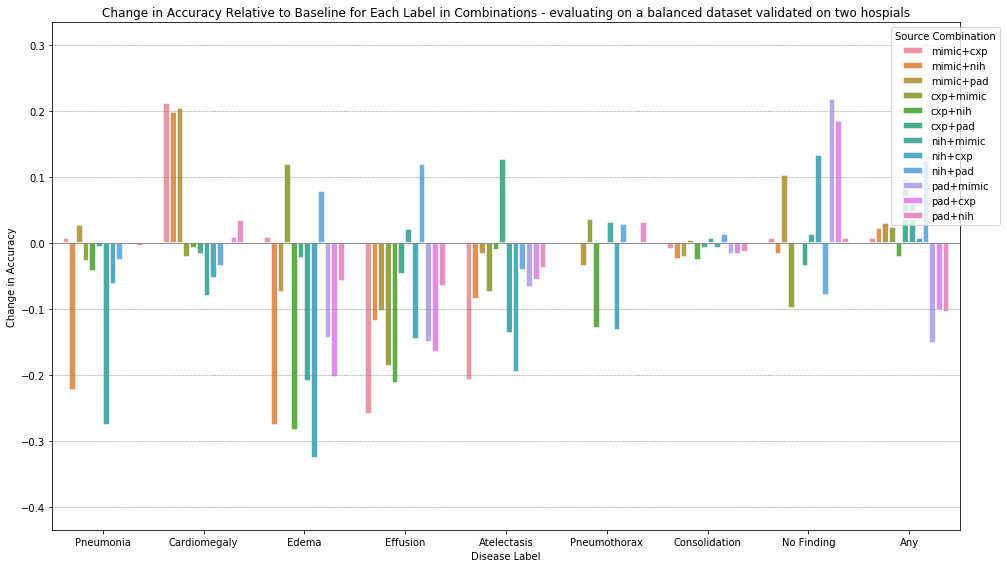

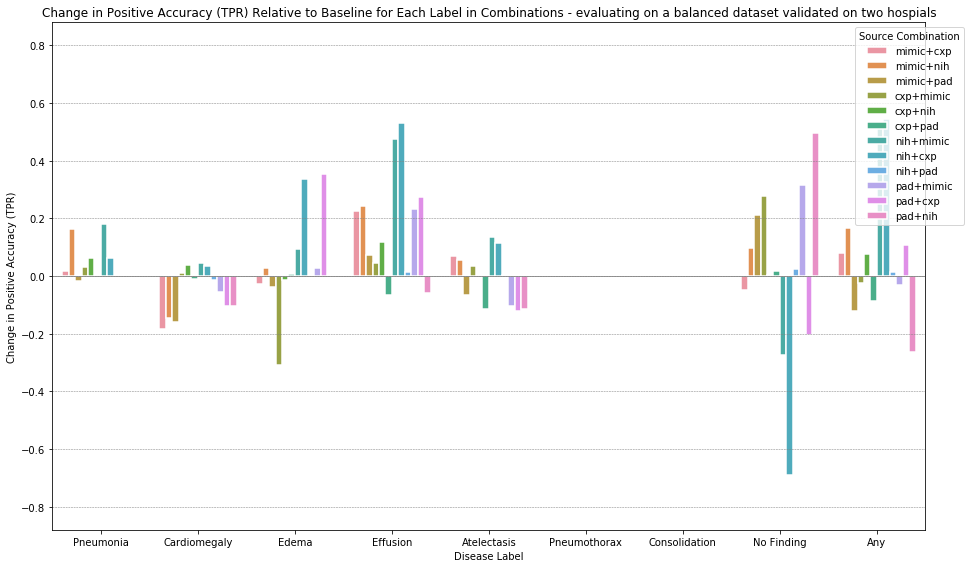

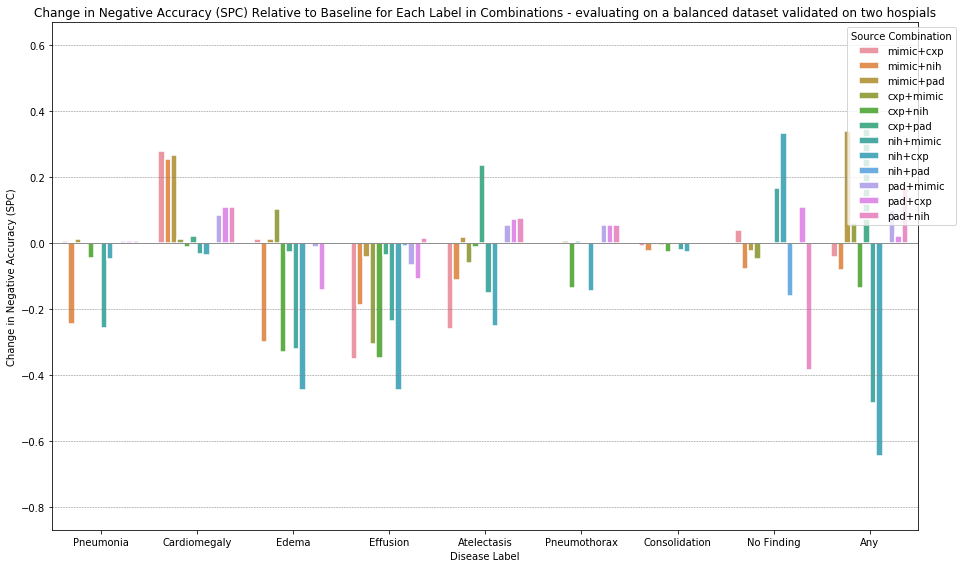

In [84]:
#commenting these out since they don't have the positive and negative accuracy changes
# plot_breakdown_accuracy_changes(two_datasets_accuracy_changes_df, "evaluating on two datasets")
# plot_breakdown_accuracy_changes(one_datasets_accuracy_changes_df, "evaluating on one dataset")
# plot_breakdown_accuracy_changes(balanced_dataset_accuracy_changes_df, "evaluating on a balanced datasets")
# plot_breakdown_accuracy_changes(balanced_single_dataset_accuracy_changes_df, "evaluating on a balanced single dataset")

# plot_breakdown_accuracy_changes(balanced_min_max_dataset_accuracy_changes_df, "evaluating on a balanced min max dataset")

# plot_breakdown_accuracy_changes(balanced_min_max_dataset_accuracy_changes_df, metric='Accuracy', chart_name='evaluating on a balanced min max dataset')
# plot_breakdown_accuracy_changes(balanced_min_max_dataset_accuracy_changes_df, metric='Positive Accuracy (TPR)', chart_name='evaluating on a balanced min max dataset')
# plot_breakdown_accuracy_changes(balanced_min_max_dataset_accuracy_changes_df, metric='Negative Accuracy (SPC)', chart_name='evaluating on a balanced min max dataset')

plot_breakdown_accuracy_changes(balanced_validate_on_two_dataset_accuracy_changes_df, metric='Accuracy', chart_name='evaluating on a balanced dataset validated on two hospials')
plot_breakdown_accuracy_changes(balanced_validate_on_two_dataset_accuracy_changes_df, metric='Positive Accuracy (TPR)', chart_name='evaluating on a balanced dataset validated on two hospials')
plot_breakdown_accuracy_changes(balanced_validate_on_two_dataset_accuracy_changes_df, metric='Negative Accuracy (SPC)', chart_name='evaluating on a balanced dataset validated on two hospials')

In [85]:
def plot_accuracy_per_dataset(report, chart_name=""):
    dataset_names = ['nih', 'mimic', 'pad', 'cxp']

    for dataset_name in dataset_names:
        dataset_specific = report[report['source'].str.contains(dataset_name)]

        sorted_sources = sorted(dataset_specific['source'].unique(), key=lambda x: (x.count('+'), x != dataset_name))
        dataset_specific = dataset_specific[dataset_specific['source'].isin(sorted_sources)].sort_values(by='source', key=lambda x: x.map(dict(zip(sorted_sources, range(len(sorted_sources))))))

        plt.figure(figsize=(12, 6))

        ax = sns.barplot(data=dataset_specific, x='Label', y='Accuracy', hue='source', palette='tab20')

        for y in ax.get_yticks():
            plt.axhline(y, color='gray', linewidth=0.5, linestyle='--')

        plt.title(f'Comparison of Model Accuracies by Disease Label for {dataset_name.upper()} {" for " + chart_name if chart_name else None}')
        plt.ylabel('Accuracy')
        plt.xlabel('Disease Label')
        plt.xticks()
        plt.legend(title='Source', loc='lower right')

        plt.tight_layout()

        # Show the plot
        plt.show()

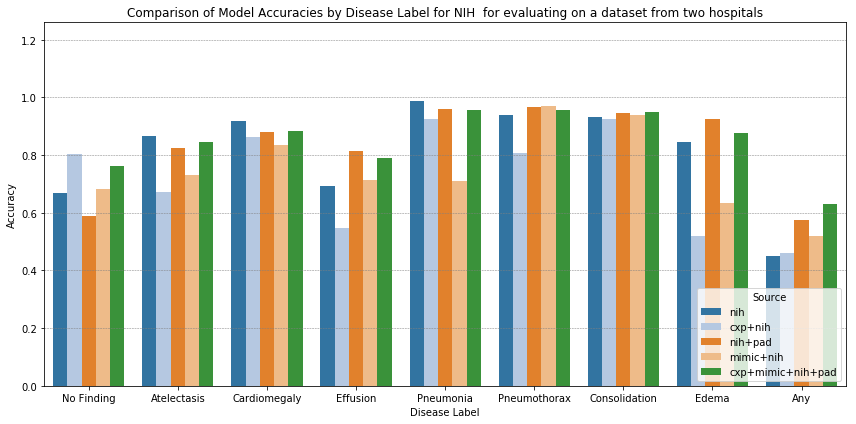

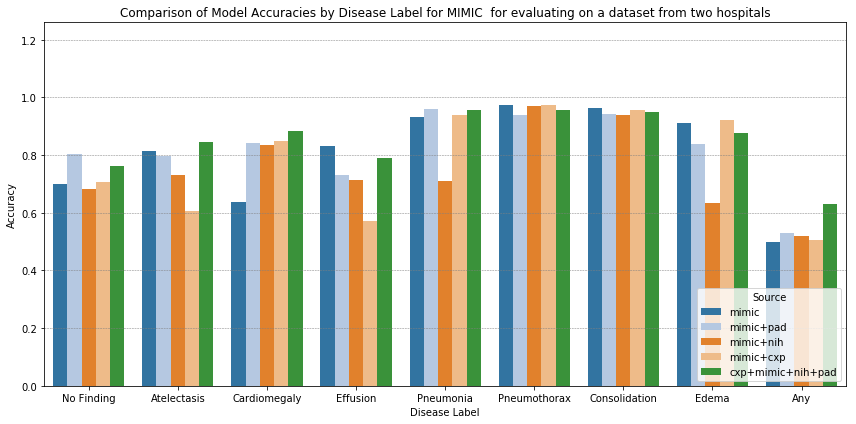

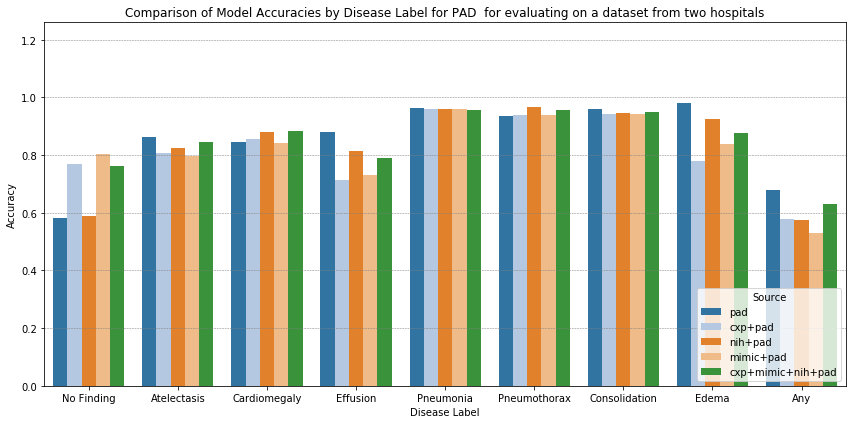

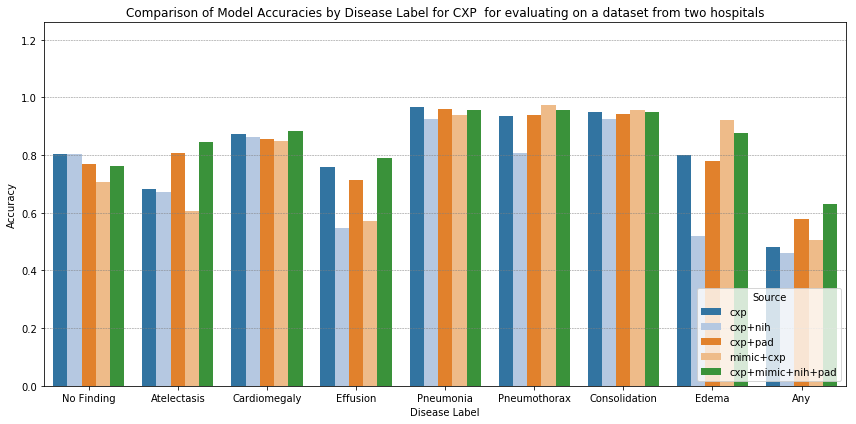

In [86]:
#commenting these out since they don't have the positive and negative accuracy changes
# plot_accuracy_per_dataset(two_dataset_combined_report, "evaluating on two datasets")
# plot_accuracy_per_dataset(one_dataset_combined_report, "evaluating on one dataset")
# plot_accuracy_per_dataset(balanced_dataset_combined_report, "evaluating on a balanced datasets")
# plot_accuracy_per_dataset(balanced_single_dataset_combined_report, "evaluating on a balanced single dataset")


# plot_accuracy_per_dataset(balanced_min_max_dataset_combined_report, "evaluating on a balanced min max dataset")


plot_accuracy_per_dataset(balanced_validate_on_two_dataset_combined_report, "evaluating on a dataset from two hospitals")

# Results

I had a mixed bag results as is seen from the graphs above. Let's dive in.

Original paper results:
![Paper results comparison](https://raw.githubusercontent.com/nstawski/dlh-final-project/main/img/Figure_2_article.png)

My closest results:
![My closest results comparison](https://raw.githubusercontent.com/nstawski/dlh-final-project/main/img/Accuracy-per-label-validated_on_two_hospitals.png)

My initial results:
![My results comparison](https://raw.githubusercontent.com/nstawski/dlh-final-project/main/img/Accuracy-per-label.png)

As it is seen from the tables above, I got a significantly different result than the artcile authors. Most accuracy changes from incorporating a second dataset were positive (most impacting in the CXP case), and the negative ones were not as bad as the article stated.

## Ablation study

To make sure I am not missing anything, I have repeated the training and the study on the following dataset combinations for training, test and validation:

* Unbalanced dataset
    * train on single (for example, CXP), validate on combined dataset (for example, CXP+NIH)
    * train on combined (for example, CXP+NIH), validate on combined dataset (for example, CXP+NIH)
    * train on combined (for example, CXP+NIH), validate on single dataset (for example, just CXP)
* Balanced dataset
    * train on single (for example, CXP), validate on combined dataset (for example, CXP+NIH)
    * train on combined (for example, CXP+NIH), validate on combined dataset (for example, CXP+NIH)
    * train on combined (for example, CXP+NIH), validate on single dataset (for example, just CXP)
    
I also re-run the training on different sized results (skip every 20th entry vs every 30th), and in one case ran the study on the full amount of data for one combination.

Balancing affected the results slightly, but I still didn't get the picture that the authors of the article got.

When comparing the balanced vs unbalanced dataset validation, the pattern stays the same.

Unbalanced dataset:
![Unbalanced dataset](https://raw.githubusercontent.com/nstawski/dlh-final-project/main/img/Accuracy-per-label-two-datasets.png)
Balanced dataset:
![Balanced dataset](https://raw.githubusercontent.com/nstawski/dlh-final-project/main/img/Accuracy-per-label-balanced-dataset.png)

When both training and validating on two datasets, the margin of error on accuracy was very small.

#### Reproducing the results (the closest I got)

The closest results to the paper study I got with a balanced dataset that was evaluating on the two hospital data even if trained with a single hospital.

![My closest results comparison](https://raw.githubusercontent.com/nstawski/dlh-final-project/main/img/Accuracy-per-label-validated_on_two_hospitals.png)

## Model comparison

# Discussion

## Is the paper reproducible?
Partially. My resulting visualization ended up being different from the one authors used in the article. However, looking at the results, especially when they are broken down by dataset, one can get to pretty much the same response as the authors of the article did: "It depends", and it looks like balancing the dataset, just as the article stated, doesn't always improve the outcome.

When you look at the results for individual datasets and the resulting combinations, the answer to the main question is very different depending on the dataset:

![Accuracy-PAD](https://raw.githubusercontent.com/nstawski/dlh-final-project/main/img/Accuracy-PAD.png)
For PAD, the improvements from adding the second dataset were mainly for the "No finding" category, and the rest generally, even though very slightly, performed worse.

![Accuracy-MIMIC](https://raw.githubusercontent.com/nstawski/dlh-final-project/main/img/Accuracy-MIMIC.png)
For MIMIC, the answer is "more-or-less", although we can see the very slight positive improvement for most labels.

![Accuracy-NIH](https://raw.githubusercontent.com/nstawski/dlh-final-project/main/img/Accuracy-NIH.png)
For NIH, again, the performance mostly decreased.

![Accuracy-CXP](https://raw.githubusercontent.com/nstawski/dlh-final-project/main/img/Accuracy-CXP.png)
One interesting exception, CXP almost always significantly benefitted from adding more datasets.

## If the paper is _not_ reproducible, explain the results
A portion of the code provided by the article authors was runnable with minimal updates. I was able to reproduce the initial dataset statistics, but wasn't able to run the training code at all.

As a result, I followed the general guidelines given by the authors of the article and wrote my own code - so this may have affected the resulting data I got.

Another factor that might have influenced the resulting data was in data pre-processing. While trying to adapt the authors' code, I discovered an inconsistency in the dataset processing: in some cases the values for certain labels were `True/False`, in some cases numeric `0/1`, and in some cases other numeric value or even a `NaN`.

When adapting the code, I corrected the processing functions so they yield similar-looking results for ease of the combination in a single dataset.

## What was easy
The authors did a great job documenting some parts of the project, for example, access to data. Following the instructions was very easy, and while MIMIC-CXR-JPG dataset access took some time to get, overall the process was a breeze.

## What was difficult
Downloading the datasets is a hassle though, I ran out of space on my laptop, had to buy an external drive and restart the download process for MIMIC-CXR-JPG a few times. In the end, I got a message from my provider that my namely "unlimited" internet for the months was used 100% and I will be charged for each extra GB I use.

There are a few notebooks and standalone scripts provided to process the data. While it is possible to figure out what steps need to be done in what order, many of the parts of the process are not documented. 'pyproject.toml' did not run successfully for me, and I got stuck for a while, trying to figure out why and how to run it (I have a suspicion my processor architecture is not supported).

As a result, I opted to re-implement the training and model validation myself. There is code for training and validation in the project, which has a lot of comments (great!), but the process itself is not well documented, so the reproducer is left figuring out which steps in the code are needed and which are not, and how to adapt it to use for their experiment. The code is very general and there is a lot of it. There are some pointers in the readme, but they were not sufficient for reproducing things successfully without additional modification. wandb wasn't working for me either.

The data is not processed evenly / equally for each dataset, there are different values for the same labels (`NaN`, `True/False`, `1/0`, `1.1/0.0`). I had to write some processing code to make sure to mitigate those differences. 

Additional complication was due to the fact that the amount of data is very large. Any training or processing takes a long time, the notebook kernel dies frequently and the overall process is frustrating. Downloading MIMIC took a week and ate all my provider's internet allowance for a month. Running the training on a full dataset proved it to be difficult due to the whole different set of circumstances: I encountered out of memory issues, kernel panic, random automatic Windows updates, power outage, kids getting to the computer and switching the power supply off. In the end, the estimation to run the training on the full dataset was circa 16+ days, so I opted for running the code on the subset of the data instead. 

I tried to avoid multiple separate files and scripts, and pulled many of the data preprocessing into my notebook. However, this increased the runtime of the notebook significantly. Additional factor affecting the runtime is the size of the input data, even when working on one dataset. I was never able to achieve the 8-minute runtime, in fact, my record was around 10 hours.
  
## Suggestions for the author

Trim the codebase leaving only relevant parts. Add documentation for the training and validation process. Add some background on why wandb is used and how to use it for this project correctly. Provide a suggested order of execution for the notebooks. Provide the instructions and code to plot the results.

## Future plans

I am still very interested in answering the question why my results, even though providing a similar answer, looked so different from the article authors'. I plan to do a few more things to try and figure this out:

* Try different models (for example, `LinearSVC` and other models tried by the authors of the article before arriving on their final model), and hyperparameters
* Try and incorporate more of the training and validation code provided by the article authors, and/or triple check mine
* Run the training on the full dataset (ensuring the computer is on backup power supply and is unreachable to anyone trying to switch it off)


# References

1.   Rhys Compton; Lily Zhang; Aahlad Puli; Rajesh Ranganath, When More is Less: Incorporating Additional Datasets Can Hurt Performance By Introducing Spurious Correlations, arXiv preprint, 2023-08-09, Accepted at MLHC 2023, doi: [10.48550/arXiv.2308.04431](https://doi.org/10.48550/arXiv.2308.04431)
2.   Haoran Zhang, Natalie Dullerud, Laleh Seyyed-Kalantari, Quaid Morris, Shalmali Joshi, and Marzyeh Ghassemi. An empirical framework for domain generalization in clinical settings. In Proceedings of the Conference on Health, Inference, and Learning, pages 279–290, 2021, doi: [10.48550/arXiv.2103.11163](https://doi.org/10.48550/arXiv.2103.11163)
3.   Gao Huang, Zhuang Liu, Laurens Van Der Maaten, and Kilian Q Weinberger. Densely connected convolutional networks. In Proceedings of the IEEE conference on computer vision and pattern recognition, pages 4700–4708, 2017, doi: [10.48550/arXiv.1608.06993](https://doi.org/10.48550/arXiv.1608.06993)
4.   Jia Deng, Wei Dong, Richard Socher, Li-Jia Li, Kai Li, and Li Fei-Fei. Imagenet: A large- scale hierarchical image database. In 2009 IEEE Conference on Computer Vision and Pattern Recognition, pages 248–255, 2009, doi: [10.1109/CVPR.2009.5206848](https://doi.org/10.1109/CVPR.2009.5206848)
5.   John R Zech, Marcus A Badgeley, Manway Liu, Anthony B Costa, Joseph J Titano, and Eric Karl Oermann. Variable generalization performance of a deep learning model to detect pneumonia in chest radiographs: a cross-sectional study. PLoS medicine, 15(11): e1002683, 2018, doi: [10.1371/journal.pmed.1002683](https://doi.org/10.1371/journal.pmed.1002683)